# Regular molecules

In [ ]:
import tequila as tq
from tequila.grouping.compile_groups import compile_commuting_parts
import numpy as np
import openfermion as of
import scipy
from utils.measurement_utils import compute_num_meas

# mol = tq.Molecule(geometry="h 0.0 0.0 0.0\nh 0.0 0.0 1.5\nh 0.0 0.0 3.0\nh 0.0 0.0 4.5", basis_set="sto-3g").use_native_orbitals() # Linear H4
# mol = tq.Molecule(geometry="H 1.5 0.0 0.0\nH 0.0 0.0 0.0\nH 1.5 0.0 1.5\nH 0.0 0.0 1.5", basis_set="sto-3g").use_native_orbitals() # Square H4
# mol = tq.Molecule(geometry="h 0.0 0.0 0.0\nh 0.0 0.0 1.5\nh 0.0 0.0 3.0\nh 0.0 0.0 4.5\nh 0.0 0.0 6.0\nh 0.0 0.0 7.5", basis_set="sto-3g").use_native_orbitals() # Linear H6
# geom = """H 0.0000 1.3970 0.0000\nH 1.2098 0.6985 0.0000\nH 1.2098 -0.6985 0.0000\nH 0.0000 -1.3970 0.0000\nH -1.2098 -0.6985 0.0000\nH -1.2098 0.6985 0.0000"""
# mol = tq.Molecule(geometry=geom, basis_set="sto-3g").use_native_orbitals() # Circular H6
geom = "H 0.0 0.0 0.0\nH 0.0 0.0 1.5\nH 0.0 0.0 3.0\nH 0.0 0.0 4.5\nH 0.0 0.0 6.0\nH 0.0 0.0 7.5\nH 0.0 0.0 9.0\nH 0.0 0.0 10.5"
mol = tq.Molecule(geometry=geom, basis_set="sto-3g").use_native_orbitals() # Linear H8

H = mol.make_hamiltonian()
Hof = H.to_openfermion()
Hsparse = of.linalg.get_sparse_operator(Hof)
v,vv = scipy.sparse.linalg.eigsh(Hsparse, sigma=mol.compute_energy("fci"))
# print(f"error: {mol.compute_energy('fci') - v[0]}") # check
wfn = tq.QubitWaveFunction.from_array(vv[:,0])

# For Linear H8
# x = np.load("scenario1/h8_wfn.npy")
# wfn = tq.QubitWaveFunction.from_array(x)

# c,h,g = mol.get_integrals()
# mol = tq.Molecule(geometry=mol.parameters.geometry, nuclear_repulsion=0.0, one_body_integrals=np.zeros(shape=[np.shape(h)[0],np.shape(h)[1]]),
#                   two_body_integrals=g, basis_set=mol.parameters.basis_set)

measurements = {}

## LF, RLF, SI

In [ ]:
import tequila as tq
from tequila.grouping.compile_groups import compile_commuting_parts

H = mol.make_hamiltonian()
print(f"len(H): {len(H)}")

options = {
    'method': 'lf', # lf, rlf, si, ics, lr, fff-lr
    'condition': 'fc', # qwc, fc
    'optimize': 'yes',
    'n_el': mol.n_electrons
}
fc_groups_and_unitaries, sample_ratios = compile_commuting_parts(H, unitary_circuit='improved', options=options)

number_fc_groups = len(fc_groups_and_unitaries)
print(f'method: {options["method"]}, condition: {options["condition"]}')
print('The number of groups to measure is: ', number_fc_groups)
E = tq.ExpectationValue(H=H, U=tq.QCircuit(), optimize_measurements=options)
md = 0
counter = 0
for e in E.get_expectationvalues():
    depth = tq.compile_circuit(e.U).depth
    if depth > md: md = depth

    cnots = 0
    for g in tq.compile_circuit(e.U).gates:
        if g.control:
            cnots += 1
    # print(cnots)
    if cnots > counter: counter = cnots
print("depth overhead: ", md)
print("CNOTs: ", counter)

groups = []
transformations = []
for group, circuit in fc_groups_and_unitaries:
    groups.append(group)
    transformations.append(circuit)
M_tot = compute_num_meas(wfn, groups, transformations, molecule=mol)
print(f"M_tot: {M_tot:e}")
measurements[options['method']] = [number_fc_groups, md, counter, M_tot]

len(H): 3985
method: lf, condition: fc
The number of groups to measure is:  154
depth overhead:  123
CNOTs:  260


In [ ]:
import tequila as tq
from tequila.grouping.compile_groups import compile_commuting_parts 

H = mol.make_hamiltonian()
print(f"len(H): {len(H)}")

options = {
    'method': 'rlf', # lf, rlf, si, ics, lr, fff-lr
    'condition': 'fc', # qwc, fc
    'optimize': 'yes',
    'n_el': mol.n_electrons
}
fc_groups_and_unitaries, sample_ratios = compile_commuting_parts(H, unitary_circuit='improved', options=options)

number_fc_groups = len(fc_groups_and_unitaries)
print(f'method: {options["method"]}, condition: {options["condition"]}')
print('The number of groups to measure is: ', number_fc_groups)
E = tq.ExpectationValue(H=H, U=tq.QCircuit(), optimize_measurements=options)
md = 0
for e in E.get_expectationvalues():
    depth = tq.compile_circuit(e.U).depth
    if depth > md: md = depth

    cnots = 0
    for g in tq.compile_circuit(e.U).gates:
        if g.control:
            cnots += 1
    # print(cnots)
    if cnots > counter: counter = cnots
print("depth overhead: ", md)
print("CNOTs: ", counter)

groups = []
transformations = []
for group, circuit in fc_groups_and_unitaries:
    groups.append(group)
    transformations.append(circuit)
M_tot = compute_num_meas(wfn, groups, transformations, molecule=mol)
print(f"M_tot: {M_tot:e}")
measurements[options['method']] = [number_fc_groups, md, counter, M_tot]

len(H): 3985
method: rlf, condition: fc
The number of groups to measure is:  111
depth overhead:  129
CNOTs:  260


In [ ]:
import tequila as tq
from tequila.grouping.compile_groups import compile_commuting_parts

H = mol.make_hamiltonian()
print(f"len(H): {len(H)}")

options = {
    'method': 'si', # lf, rlf, si, ics, lr, fff-lr
    'condition': 'fc', # qwc, fc
    'optimize': 'yes',
    'n_el': mol.n_electrons
}
fc_groups_and_unitaries, sample_ratios = compile_commuting_parts(H, unitary_circuit='improved', options=options)

number_fc_groups = len(fc_groups_and_unitaries)
print(f'method: {options["method"]}, condition: {options["condition"]}')
print('The number of groups to measure is: ', number_fc_groups)
E = tq.ExpectationValue(H=H, U=tq.QCircuit(), optimize_measurements=options)
md = 0
for e in E.get_expectationvalues():
    depth = tq.compile_circuit(e.U).depth
    if depth > md: md = depth

    cnots = 0
    for g in tq.compile_circuit(e.U).gates:
        if g.control:
            cnots += 1
    # print(cnots)
    if cnots > counter: counter = cnots
print("depth overhead: ", md)
print("CNOTs: ", counter)

groups = []
transformations = []
for group, circuit in fc_groups_and_unitaries:
    groups.append(group)
    transformations.append(circuit)
M_tot = compute_num_meas(wfn, groups, transformations, molecule=mol, debug=True, n_repetitions=100)
# M_tot = compute_num_meas(wfn, groups, transformations, molecule=mol, debug=False)
print(f"M_tot: {M_tot:e}")
measurements[options['method']] = [number_fc_groups, md, counter, M_tot]

len(H): 3985


KeyboardInterrupt: 

## Samples SI

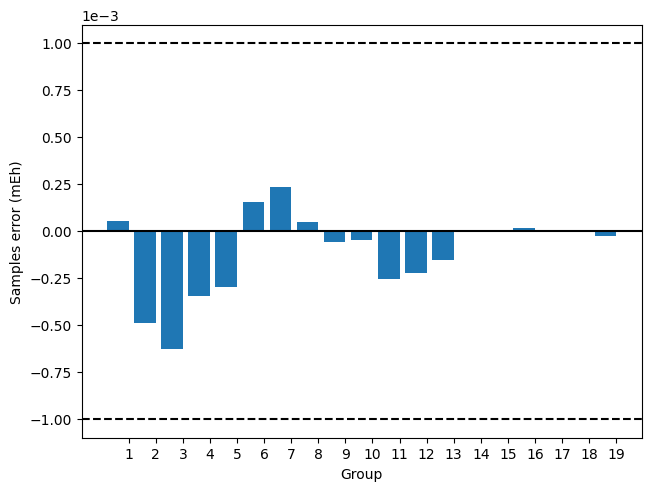

In [ ]:
# Linear H4 SI Samples
import matplotlib.pyplot as plt
import numpy as np

species = tuple(str(i) for i in range(1, 20))
penguin_means = {
    'Linear H4': (5.432911e-05, -4.888099e-04, -6.254319e-04, -3.457734e-04, -2.991101e-04,
                  1.530546e-04, 2.322388e-04, 4.832407e-05, -5.559627e-05, -4.565844e-05,
                  -2.563117e-04, -2.232106e-04, -1.543160e-04, 7.159503e-06, -1.503322e-06,
                  1.775569e-05, 1.925667e-06, -4.508511e-06, -2.695349e-05)
}

x = np.arange(len(species))  # the label locations
width = 0.8  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Overhead in circuit depth')
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
# ax.legend()
# ax.set_ylim(0, 240)
# ax.set(xticklabels=[])

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylabel('Samples error (mEh)')
plt.xlabel('Group')

plt.axhline(y=1e-3, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.axhline(y=-1e-3, color='k', linestyle='--')
plt.savefig('filename.png', dpi=300)

plt.show()

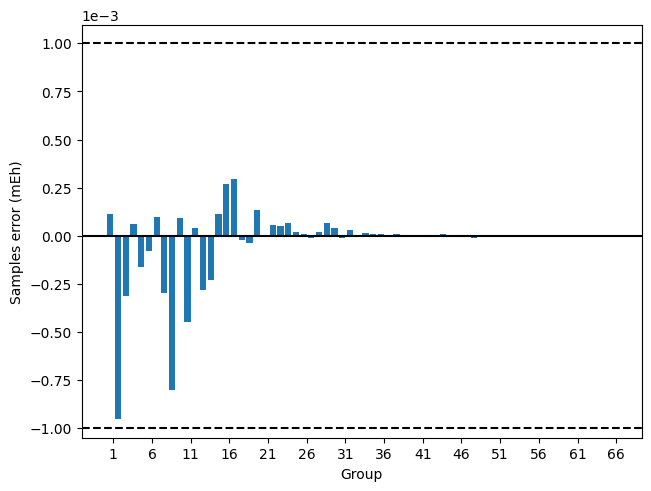

In [13]:
# Linear H6 SI Samples
import matplotlib.pyplot as plt
import numpy as np

species = tuple(str(i) for i in range(1, 67))
penguin_means = {
    'Linear H6': (1.152819e-04, -9.515466e-04, -3.104716e-04, 6.137893e-05, -1.612424e-04,
                -8.035134e-05, 9.745441e-05, -2.996505e-04, -8.013587e-04, 9.184445e-05,
                -4.491228e-04, 3.967621e-05, -2.830486e-04, -2.310970e-04, 1.111233e-04,
                2.671172e-04, 2.944249e-04, -1.938981e-05, -3.849819e-05, 1.324780e-04,
                4.275601e-07, 5.374402e-05, 5.138555e-05, 6.761292e-05, 1.797444e-05,
                7.670079e-06, -1.367712e-05, 1.878894e-05, 6.580338e-05, 4.100075e-05,
                -9.593508e-06, 2.989510e-05, -2.241936e-06, 1.257864e-05, 7.655159e-06,
                8.021677e-06, 4.617795e-06, 1.108207e-05, 5.767617e-06, -1.910730e-06,
                4.404766e-06, 3.314900e-06, -5.362748e-06, 8.716465e-06, -4.314368e-07,
                1.815460e-06, -8.241949e-06, -1.120518e-05, 8.603588e-07, -9.950292e-08,
                -5.232485e-07, 1.647848e-07, 7.862183e-07, 2.536512e-08, 1.521612e-07,
                -2.722665e-07, 3.885999e-08, -2.334532e-07, -1.622416e-07, -2.481057e-08,
                -2.358643e-07, 6.690714e-08, -6.509256e-08, 4.610742e-08, 3.364338e-07,
                1.067524e-07)
}

x = np.arange(len(species))  # the label locations
width = 0.8  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Overhead in circuit depth')
# ax.set_title('Penguin attributes by species')
ax.set_xticks((x + width)[::5], species[::5])
# ax.legend()
# ax.set_ylim(0, 240)
# ax.set(xticklabels=[])

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylabel('Samples error (mEh)')
plt.xlabel('Group')

plt.axhline(y=1e-3, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.axhline(y=-1e-3, color='k', linestyle='--')
plt.savefig('filename.png', dpi=300)

plt.show()

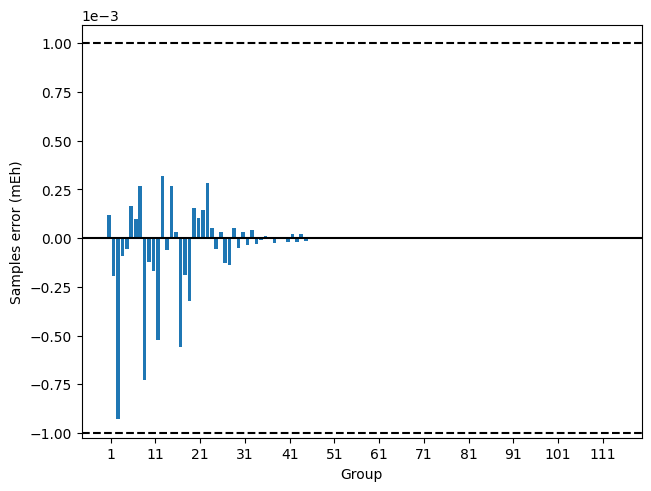

In [14]:
# Linear H8 SI Samples
import matplotlib.pyplot as plt
import numpy as np

species = tuple(str(i) for i in range(1, 115))
penguin_means = {
    'Linear H8': (1.175915e-04, -1.951759e-04, -9.282955e-04, -9.114974e-05, -5.711962e-05,
                    1.654258e-04, 9.657602e-05, 2.680978e-04, -7.297897e-04, -1.235080e-04,
                    -1.694276e-04, -5.247049e-04, 3.209990e-04, -5.873945e-05, 2.653679e-04,
                    3.073116e-05, -5.567826e-04, -1.889963e-04, -3.233827e-04, 1.533978e-04,
                    1.051570e-04, 1.464786e-04, 2.817396e-04, 5.046780e-05, -5.618139e-05,
                    2.944381e-05, -1.255552e-04, -1.390327e-04, 5.282934e-05, -5.167311e-05,
                    2.983407e-05, -3.442574e-05, 4.119634e-05, -2.943462e-05, -8.888177e-06,
                    1.150781e-05, 1.524110e-06, -2.767367e-05, -1.399531e-06, -5.247039e-06,
                    -1.875404e-05, 2.155378e-05, -1.856498e-05, 2.208803e-05, -1.572253e-05,
                    5.791433e-06, 7.262418e-08, 1.699134e-07, 3.187900e-06, -4.409370e-06,
                    -2.254421e-06, 1.577718e-06, -2.173140e-06, 7.464669e-07, 1.825564e-06,
                    3.280266e-06, 6.713847e-06, -9.790264e-07, 3.702715e-07, 4.029046e-06,
                    2.252777e-06, -2.382111e-06, -6.297891e-06, -9.273291e-07, -3.527446e-07,
                    2.018670e-06, -1.793295e-06, -1.872472e-06, -3.426569e-06, 9.510643e-07,
                    1.427485e-07, 3.675362e-08, 7.916107e-07, -4.436270e-07, 8.374912e-07,
                    -6.993944e-07, -7.426803e-07, -8.109501e-07, -9.834260e-08, 6.230028e-07,
                    -4.233394e-07, -5.126414e-07, -4.896016e-07, -2.083691e-07, -6.492610e-07,
                    -1.048871e-07, 6.041851e-09, 4.342078e-08, 6.412763e-08, -3.433735e-08,
                    -2.748045e-08, 8.630256e-08, 5.683618e-08, -1.053880e-07, -8.724420e-09,
                    1.274010e-07, -4.675980e-08, 1.617943e-07, -4.997959e-09, 1.368054e-07,
                    -7.925305e-08, 5.975974e-08, 3.323573e-08, -1.387251e-07, 3.983587e-08,
                    5.875529e-08, 7.793054e-09, 1.301667e-07, 3.876528e-08, 5.737926e-09,
                    0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00)
}

x = np.arange(len(species))  # the label locations
width = 0.8  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Overhead in circuit depth')
# ax.set_title('Penguin attributes by species')
ax.set_xticks((x + width)[::10], species[::10])
# ax.legend()
# ax.set_ylim(0, 240)
# ax.set(xticklabels=[])

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylabel('Samples error (mEh)')
plt.xlabel('Group')

plt.axhline(y=1e-3, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.axhline(y=-1e-3, color='k', linestyle='--')
plt.savefig('filename.png', dpi=300)

plt.show()

## ICS, LR, FFF-LR

In [15]:
# import tequila as tq
# from tequila.grouping.compile_groups import compile_commuting_parts

# import tequila as tq
# from tequila.hamiltonian import QubitHamiltonian, PauliString
# from tequila.grouping.binary_rep import BinaryPauliString, BinaryHamiltonian
# from tequila.grouping.fermionic_functions import n_elec
# from tequila.grouping.fermionic_methods import get_wavefunction
# import numpy as np

# H = mol.make_hamiltonian()
# print(f"len(H): {len(H)}")

# Hbin = BinaryHamiltonian.init_from_qubit_hamiltonian(H)
# _, psis_appr = get_wavefunction(H.to_openfermion(), "cisd", f"h{mol.n_electrons}", mol.n_electrons, save=False)
# # print(mol, H, Hbin, psis_appr[0], len(Hbin.binary_terms) - 1)
# n_paulis = len(Hbin.binary_terms) - 1
# psi_appr = psis_appr[0]

# def prepare_cov_dict(H, psi_appr):
#     '''
#     Return the covariance dictionary containing Cov(P1, P2). 
#     In a practical calculation, this covariance dictionary would be built from
#     a Hartree-Fock or configuration interaction singles and doulbes (CISD) 
#     wavefunction. Here, we use the CISD wavefunction.
#     '''
#     terms = H.binary_terms
#     cov_dict = {}
#     wfn0 = tq.QubitWaveFunction(psi_appr)
#     for idx, term1 in enumerate(terms):
#         for term2 in terms[idx:]:
#             pw1 = BinaryPauliString(term1.get_binary(), 1.0)
#             pw2 = BinaryPauliString(term2.get_binary(), 1.0)
#             op1 = QubitHamiltonian.from_paulistrings(pw1.to_pauli_strings())
#             op2 = QubitHamiltonian.from_paulistrings(pw2.to_pauli_strings())
#             if pw1.commute(pw2):
#                 prod_op = op1 * op2
#                 cov_dict[(term1.binary_tuple(), term2.binary_tuple())] = wfn0.inner(prod_op(wfn0)) - wfn0.inner(op1(wfn0)) * wfn0.inner(op2(wfn0))
#     return cov_dict

# # mol, H, Hbin, psi_appr, n_paulis = prepare_test_hamiltonian()
# print("Number of Pauli products to measure: {}".format(n_paulis))
# cov_dict = prepare_cov_dict(Hbin, psi_appr)

# options = {
#     'method': 'ics', # lf, rlf, si, ics, lr, fff-lr
#     'condition': 'fc', # qwc, fc
#     'optimize': 'yes',
#     'n_el': mol.n_electrons,
#     'cov_dict': cov_dict
# }
# fc_groups_and_unitaries, sample_ratios = compile_commuting_parts(H, unitary_circuit='improved', options=options)

# number_fc_groups = len(fc_groups_and_unitaries)
# print(f'method: {options["method"]}, condition: {options["condition"]}')
# print('The number of groups to measure is: ', number_fc_groups)
# E = tq.ExpectationValue(H=H, U=tq.QCircuit(), optimize_measurements=options)
# md = 0
# for e in E.get_expectationvalues():
#     depth = tq.compile_circuit(e.U).depth
#     # print(depth)
#     if depth > md: md = depth
# print("depth overhead: ", md)

# groups = []
# transformations = []
# for group, circuit in fc_groups_and_unitaries:
#     groups.append(group)
#     transformations.append(circuit)
# M_tot = compute_num_meas(wfn, groups, transformations, molecule=mol)
# print(f"M_tot: {M_tot:e}")
# measurements[options['method']] = [number_fc_groups, md, M_tot]

In [ ]:
import tequila as tq
from tequila.grouping.compile_groups import compile_commuting_parts 

H = mol.make_hamiltonian()
print(f"len(H): {len(H)}")

options = {
    'method': 'lr', # lf, rlf, si, ics, lr, fff-lr
    'condition': 'fc', # qwc, fc
    'optimize': 'yes',
    'n_el': mol.n_electrons
}
fc_groups_and_unitaries, sample_ratios = compile_commuting_parts(H, unitary_circuit='improved', options=options)

number_fc_groups = len(fc_groups_and_unitaries)
print(f'method: {options["method"]}, condition: {options["condition"]}')
print('The number of groups to measure is: ', number_fc_groups)
E = tq.ExpectationValue(H=H, U=tq.QCircuit(), optimize_measurements=options)
md = 0
for e in E.get_expectationvalues():
    depth = tq.compile_circuit(e.U).depth
    if depth > md: md = depth

    cnots = 0
    for g in tq.compile_circuit(e.U).gates:
        if g.control:
            cnots += 1
    # print(cnots)
    if cnots > counter: counter = cnots
print("depth overhead: ", md)
print("CNOTs: ", counter)

groups = []
transformations = []
for group, circuit in fc_groups_and_unitaries:
    groups.append(group)
    transformations.append(circuit)
M_tot = compute_num_meas(wfn, groups, transformations, molecule=mol)
print(f"M_tot: {M_tot:e}")
measurements[options['method']] = [number_fc_groups, md, counter, M_tot]

len(H): 3985
Using default reverse_H_transf, i.e., reverse_jordan_wigner.
Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 2.9603352099969383e-09, using 32 fragments
Finished SVD routine


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:399: ComplexWarning: Casting complex values to real discards the imaginary part
  TBTS[i,:,:,:,:] = tbt_svd
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:400: ComplexWarning: Casting complex values to real discards the imaginary part
  CARTAN_TBTS[i,:,:,:,:] = tbt_svd_CSA
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:421: ComplexWarning: Casting complex values to real discards the imaginary part
  U_ARR[i,:,:] = U_l
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:491: ComplexWarning: Casting complex values to real discards the imaginary part
  elements_sum[iidx, jidx] += opspar[iindx, jindx]


Allocating measurements


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:


method: lr, condition: fc
The number of groups to measure is:  33
Using default reverse_H_transf, i.e., reverse_jordan_wigner.
Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 2.9603352099969383e-09, using 32 fragments
Finished SVD routine
Allocating measurements
depth overhead:  232
CNOTs:  480


In [ ]:
import tequila as tq
from tequila.grouping.compile_groups import compile_commuting_parts

H = mol.make_hamiltonian()
print(f"len(H): {len(H)}")

options = {
    'method': 'fff-lr', # lf, rlf, si, ics, lr, fff-lr
    'condition': 'fc', # qwc, fc
    'optimize': 'yes',
    'n_el': mol.n_electrons
}
fc_groups_and_unitaries, sample_ratios = compile_commuting_parts(H, unitary_circuit='improved', options=options)

number_fc_groups = len(fc_groups_and_unitaries)
print(f'method: {options["method"]}, condition: {options["condition"]}')
print('The number of groups to measure is: ', number_fc_groups)
E = tq.ExpectationValue(H=H, U=tq.QCircuit(), optimize_measurements=options)
md = 0
for e in E.get_expectationvalues():
    depth = tq.compile_circuit(e.U).depth
    if depth > md: md = depth

    cnots = 0
    for g in tq.compile_circuit(e.U).gates:
        if g.control:
            cnots += 1
    # print(cnots)
    if cnots > counter: counter = cnots
print("depth overhead: ", md)
print("CNOTs: ", counter)

groups = []
transformations = []
for group, circuit in fc_groups_and_unitaries:
    groups.append(group)
    transformations.append(circuit)
M_tot = compute_num_meas(wfn, groups, transformations, molecule=mol)
print(f"M_tot: {M_tot:e}")
measurements[options['method']] = [number_fc_groups, md, counter, M_tot]

len(H): 1623
Using default reverse_H_transf, i.e., reverse_jordan_wigner.


Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 2.0443288254359863e-17, using 21 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 22
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

Progress: iteration #1 out of 5
Progress: iteration #2 out of 5
Progress: iteration #3 out of 5
Progress: iteration #4 out of 5
Progress: iteration #5 out of 5
Allocating measurements
method: fff-lr, condition: fc
The number of groups to measure is:  22
Using default reverse_H_transf, i.e., reverse_jordan_wigner.


Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 2.0443288254359863e-17, using 21 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 22
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

Progress: iteration #1 out of 5
Progress: iteration #2 out of 5
Progress: iteration #3 out of 5
Progress: iteration #4 out of 5
Progress: iteration #5 out of 5
Allocating measurements
depth overhead:  168
CNOTs:  264


In [ ]:
measurements
## Linear H4 ##
# {'lf': [28, 47, 118949.73544498537],
#  'rlf': [19, 41, 49904.55348814035],
#  'si': [19, 32, 34871.21698003363],
#  'lr': [10, 104, 1199635.4433151886],
#  'fff-lr': [10, 105, 38912.91057558841]}

## Square H4 ##
# {'lf': [21, 43, 64150.551020041836],
#  'rlf': [22, 43, 99403.45369416286],
#  'si': [19, 32, 27712.17937219008],
#  'lr': [11, 104, 1672641.6714564916],
#  'fff-lr': [11, 104, 1552433.9469066726]}

## Linear H6 ##
# {'lf': [90, 78, 191024.99904914168],
#  'rlf': [60, 73, 222457.21092071215],
#  'si': [66, 56, 35815.087143647645],
#  'lr': [22, 168, 1645934.6325189292],
#  'fff-lr': [22, 168, 37446.36245279067]}

## Circular H6 ##
# {'lf': [91, 80, 351052.5630786216],
#  'rlf': [64, 83, 270870.57981165306],
#  'si': [69, 54, 42714.74804871854],
#  'lr': [22, 168, 2681934.3503146875],
#  'fff-lr': [22, 168, 2580472.551749848]}

## Linear H8 ##
# {'lf': [154, 123, 268854.5162964303],
#  'rlf': [111, 129, 258924.1046839412],
#  'si': [114, 81, 36005.7162727797],
#  'lr': [33, 232, 2379372.2461141017],
#  'fff-lr': [33, 233, 31798.44260337252]}

{'lf': [90, 78, 119],
 'rlf': [60, 73, 119],
 'si': [66, 56, 119],
 'lr': [22, 168, 264],
 'fff-lr': [22, 168, 264]}

# Free H6

In [ ]:
# gin H6
import tequila as tq
from tequila.grouping.compile_groups import compile_commuting_parts 
import tequila as tq
from tequila.hamiltonian import QubitHamiltonian, PauliString
from tequila.grouping.binary_rep import BinaryPauliString, BinaryHamiltonian
from tequila.grouping.fermionic_functions import n_elec
from tequila.grouping.fermionic_methods import get_wavefunction
import numpy as np
import pandas as pd
from utils.measurement_utils import compute_num_meas
import openfermion as of
import scipy

df = pd.read_csv("h6_100")
df = df.iloc[:,10:]

n_molecules = []

for k in range(100):
    measurements = {}
    print(f"Molecule n{k}")

    # Define geometry
    geometry = f"""
H {df["x_0"][k]} {df["y_0"][k]} {df["z_0"][k]}
H {df["x_1"][k]} {df["y_1"][k]} {df["z_1"][k]}
H {df["x_2"][k]} {df["y_2"][k]} {df["z_2"][k]}
H {df["x_3"][k]} {df["y_3"][k]} {df["z_3"][k]}
H {df["x_4"][k]} {df["y_4"][k]} {df["z_4"][k]}
H {df["x_5"][k]} {df["y_5"][k]} {df["z_5"][k]}
"""

    mol = tq.Molecule(geometry=geometry, basis_set="sto-3g").use_native_orbitals()
    H = mol.make_hamiltonian()
    print(f"len(H): {len(H)}")
    measurements['original'] = len(H)

    Hof = H.to_openfermion()
    Hsparse = of.linalg.get_sparse_operator(Hof)
    v,vv = scipy.sparse.linalg.eigsh(Hsparse, sigma=mol.compute_energy("fci"))
    # print(f"error: {mol.compute_energy('fci') - v[0]}") # check
    wfn = tq.QubitWaveFunction.from_array(vv[:,0])
    
    ######## LF ########
    try:
        options = {
            'method': 'lf', # lf, rlf, si, ics, lr, fff-lr
            'condition': 'fc', # qwc, fc
            'optimize': 'yes',
            'n_el': mol.n_electrons
        }
        fc_groups_and_unitaries, sample_ratios = compile_commuting_parts(H, unitary_circuit='improved', options=options)

        number_fc_groups = len(fc_groups_and_unitaries)
        print(f'method: {options["method"]}, condition: {options["condition"]}')
        print('The number of groups to measure is: ', number_fc_groups)
        E = tq.ExpectationValue(H=H, U=tq.QCircuit(), optimize_measurements=options)
        md = 0
        for e in E.get_expectationvalues():
            depth = tq.compile_circuit(e.U).depth
            if depth > md: md = depth

            cnots = 0
            for g in tq.compile_circuit(e.U).gates:
                if g.control:
                    cnots += 1
            # print(cnots)
            if cnots > counter: counter = cnots
        print("depth overhead: ", md)
        print("CNOTs: ", counter)

        groups = []
        transformations = []
        for group, circuit in fc_groups_and_unitaries:
            groups.append(group)
            transformations.append(circuit)
        M_tot = compute_num_meas(wfn, groups, transformations, molecule=mol)
        print(f"M_tot: {M_tot:e}")
        measurements[options["method"]] = [number_fc_groups, md, counter, M_tot]
    except:
        pass
    
    ######## RLF ########
    try:
        options = {
            'method': 'rlf', # lf, rlf, si, ics, lr, fff-lr
            'condition': 'fc', # qwc, fc
            'optimize': 'yes',
            'n_el': mol.n_electrons
        }
        fc_groups_and_unitaries, sample_ratios = compile_commuting_parts(H, unitary_circuit='improved', options=options)

        number_fc_groups = len(fc_groups_and_unitaries)
        print(f'method: {options["method"]}, condition: {options["condition"]}')
        print('The number of groups to measure is: ', number_fc_groups)
        E = tq.ExpectationValue(H=H, U=tq.QCircuit(), optimize_measurements=options)
        md = 0
        for e in E.get_expectationvalues():
            depth = tq.compile_circuit(e.U).depth
            if depth > md: md = depth

            cnots = 0
            for g in tq.compile_circuit(e.U).gates:
                if g.control:
                    cnots += 1
            # print(cnots)
            if cnots > counter: counter = cnots
        print("depth overhead: ", md)
        print("CNOTs: ", counter)

        groups = []
        transformations = []
        for group, circuit in fc_groups_and_unitaries:
            groups.append(group)
            transformations.append(circuit)
        M_tot = compute_num_meas(wfn, groups, transformations, molecule=mol)
        print(f"M_tot: {M_tot:e}")
        measurements[options['method']] = [number_fc_groups, md, counter, M_tot]
    except:
        pass

    ######## SI ########
    try:
        options = {
            'method': 'si', # lf, rlf, si, ics, lr, fff-lr
            'condition': 'fc', # qwc, fc
            'optimize': 'yes',
            'n_el': mol.n_electrons
        }
        fc_groups_and_unitaries, sample_ratios = compile_commuting_parts(H, unitary_circuit='improved', options=options)
        
        number_fc_groups = len(fc_groups_and_unitaries)
        print(f'method: {options["method"]}, condition: {options["condition"]}')
        print('The number of groups to measure is: ', number_fc_groups)
        E = tq.ExpectationValue(H=H, U=tq.QCircuit(), optimize_measurements=options)
        md = 0
        for e in E.get_expectationvalues():
            depth = tq.compile_circuit(e.U).depth
            if depth > md: md = depth

            cnots = 0
            for g in tq.compile_circuit(e.U).gates:
                if g.control:
                    cnots += 1
            # print(cnots)
            if cnots > counter: counter = cnots
        print("depth overhead: ", md)
        print("CNOTs: ", counter)

        groups = []
        transformations = []
        for group, circuit in fc_groups_and_unitaries:
            groups.append(group)
            transformations.append(circuit)
        M_tot = compute_num_meas(wfn, groups, transformations, molecule=mol)
        print(f"M_tot: {M_tot:e}")
        measurements[options['method']] = [number_fc_groups, md, counter, M_tot]
    except:
        pass

    # ######## ICS ########
    # try:
    #     Hbin = BinaryHamiltonian.init_from_qubit_hamiltonian(H)
    #     _, psis_appr = get_wavefunction(H.to_openfermion(), "cisd", f"h{mol.n_electrons}", mol.n_electrons, save=False)
    #     # print(mol, H, Hbin, psis_appr[0], len(Hbin.binary_terms) - 1)
    #     n_paulis = len(Hbin.binary_terms) - 1
    #     psi_appr = psis_appr[0]

    #     def prepare_cov_dict(H, psi_appr):
    #         '''
    #         Return the covariance dictionary containing Cov(P1, P2). 
    #         In a practical calculation, this covariance dictionary would be built from
    #         a Hartree-Fock or configuration interaction singles and doulbes (CISD) 
    #         wavefunction. Here, we use the CISD wavefunction.
    #         '''
    #         terms = H.binary_terms
    #         cov_dict = {}
    #         wfn0 = tq.QubitWaveFunction(psi_appr)
    #         for idx, term1 in enumerate(terms):
    #             for term2 in terms[idx:]:
    #                 pw1 = BinaryPauliString(term1.get_binary(), 1.0)
    #                 pw2 = BinaryPauliString(term2.get_binary(), 1.0)
    #                 op1 = QubitHamiltonian.from_paulistrings(pw1.to_pauli_strings())
    #                 op2 = QubitHamiltonian.from_paulistrings(pw2.to_pauli_strings())
    #                 if pw1.commute(pw2):
    #                     prod_op = op1 * op2
    #                     cov_dict[(term1.binary_tuple(), term2.binary_tuple())] = wfn0.inner(prod_op(wfn0)) - wfn0.inner(op1(wfn0)) * wfn0.inner(op2(wfn0))
    #         return cov_dict

    #     # mol, H, Hbin, psi_appr, n_paulis = prepare_test_hamiltonian()
    #     print("Number of Pauli products to measure: {}".format(n_paulis))
    #     cov_dict = prepare_cov_dict(Hbin, psi_appr)

    #     options = {
    #         'method': 'ics', # lf, rlf, si, ics, lr, fff-lr
    #         'condition': 'fc', # qwc, fc
    #         'optimize': 'yes',
    #         'n_el': mol.n_electrons,
    #         'cov_dict': cov_dict
    #     }
    #     fc_groups_and_unitaries, sample_ratios = compile_commuting_parts(H, unitary_circuit='improved', options=options)
        
    #     number_fc_groups = len(fc_groups_and_unitaries)
    #     print(f'method: {options["method"]}, condition: {options["condition"]}')
    #     print('The number of groups to measure is: ', number_fc_groups)
    #     E = tq.ExpectationValue(H=H, U=tq.QCircuit(), optimize_measurements=options)
    #     md = 0
    #     for e in E.get_expectationvalues():
    #         depth = tq.compile_circuit(e.U).depth
    #         # print(depth)
    #         if depth > md: md = depth
    #     print("depth overhead: ", md)

    #     groups = []
    #     transformations = []
    #     for group, circuit in fc_groups_and_unitaries:
    #         groups.append(group)
    #         transformations.append(circuit)
    #     M_tot = compute_num_meas(wfn, groups, transformations, molecule=mol)
    #     print(f"M_tot: {M_tot:e}")
    #     measurements[options['method']] = [number_fc_groups, md, M_tot]
    # except:
    #     pass

    ######## LR ########
    try:
        options = {
            'method': 'lr', # lf, rlf, si, ics, lr, fff-lr
            'condition': 'fc', # qwc, fc
            'optimize': 'yes',
            'n_el': mol.n_electrons
        }
        fc_groups_and_unitaries, sample_ratios = compile_commuting_parts(H, unitary_circuit='improved', options=options)

        number_fc_groups = len(fc_groups_and_unitaries)
        print(f'method: {options["method"]}, condition: {options["condition"]}')
        print('The number of groups to measure is: ', number_fc_groups)
        E = tq.ExpectationValue(H=H, U=tq.QCircuit(), optimize_measurements=options)
        md = 0
        for e in E.get_expectationvalues():
            depth = tq.compile_circuit(e.U).depth
            if depth > md: md = depth

            cnots = 0
            for g in tq.compile_circuit(e.U).gates:
                if g.control:
                    cnots += 1
            # print(cnots)
            if cnots > counter: counter = cnots
        print("depth overhead: ", md)
        print("CNOTs: ", counter)

        groups = []
        transformations = []
        for group, circuit in fc_groups_and_unitaries:
            groups.append(group)
            transformations.append(circuit)
        M_tot = compute_num_meas(wfn, groups, transformations, molecule=mol)
        print(f"M_tot: {M_tot:e}")
        measurements[options['method']] = [number_fc_groups, md, counter, M_tot]
    except:
        pass

    ######## FFF-LR ########
    try:
        options = {
            'method': 'fff-lr', # lf, rlf, si, ics, lr, fff-lr
            'condition': 'fc', # qwc, fc
            'optimize': 'yes',
            'n_el': mol.n_electrons
        }
        fc_groups_and_unitaries, sample_ratios = compile_commuting_parts(H, unitary_circuit='improved', options=options)

        number_fc_groups = len(fc_groups_and_unitaries)
        print(f'method: {options["method"]}, condition: {options["condition"]}')
        print('The number of groups to measure is: ', number_fc_groups)
        E = tq.ExpectationValue(H=H, U=tq.QCircuit(), optimize_measurements=options)
        md = 0
        for e in E.get_expectationvalues():
            depth = tq.compile_circuit(e.U).depth
            if depth > md: md = depth

            cnots = 0
            for g in tq.compile_circuit(e.U).gates:
                if g.control:
                    cnots += 1
            # print(cnots)
            if cnots > counter: counter = cnots
        print("depth overhead: ", md)
        print("CNOTs: ", counter)

        groups = []
        transformations = []
        for group, circuit in fc_groups_and_unitaries:
            groups.append(group)
            transformations.append(circuit)
        M_tot = compute_num_meas(wfn, groups, transformations, molecule=mol)
        print(f"M_tot: {M_tot:e}")
        measurements[options['method']] = [number_fc_groups, md, counter, M_tot]
    except:
        pass

    n_molecules.append(measurements)
    print(n_molecules)
    print()

print(n_molecules)

Molecule n0
len(H): 1353
method: lf, condition: fc
The number of groups to measure is:  76
depth overhead:  77
CNOTs:  114
method: rlf, condition: fc
The number of groups to measure is:  52
depth overhead:  73
CNOTs:  118
method: si, condition: fc
The number of groups to measure is:  63
depth overhead:  62
CNOTs:  118
Using default reverse_H_transf, i.e., reverse_jordan_wigner.
Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 5.941865115990916e-09, using 18 fragments
Finished SVD routine


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:399: ComplexWarning: Casting complex values to real discards the imaginary part
  TBTS[i,:,:,:,:] = tbt_svd
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:400: ComplexWarning: Casting complex values to real discards the imaginary part
  CARTAN_TBTS[i,:,:,:,:] = tbt_svd_CSA
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:421: ComplexWarning: Casting complex values to real discards the imaginary part
  U_ARR[i,:,:] = U_l
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:491: ComplexWarning: Casting complex values to real discards the imaginary part
  elements_sum[iidx, jidx] += opspar[iindx, jindx]


Allocating measurements
method: lr, condition: fc
The number of groups to measure is:  19
Using default reverse_H_transf, i.e., reverse_jordan_wigner.
Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 5.941865115990916e-09, using 18 fragments
Finished SVD routine
Allocating measurements
depth overhead:  168
CNOTs:  264
Using default reverse_H_transf, i.e., reverse_jordan_wigner.


Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 5.941865115990916e-09, using 18 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 19
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

Progress: iteration #1 out of 5
Progress: iteration #2 out of 5
Progress: iteration #3 out of 5
Progress: iteration #4 out of 5
Progress: iteration #5 out of 5
Allocating measurements
method: fff-lr, condition: fc
The number of groups to measure is:  19
Using default reverse_H_transf, i.e., reverse_jordan_wigner.


Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 5.941865115990916e-09, using 18 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 19
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

Progress: iteration #1 out of 5
Progress: iteration #2 out of 5
Progress: iteration #3 out of 5
Progress: iteration #4 out of 5
Progress: iteration #5 out of 5
Allocating measurements
depth overhead:  168
CNOTs:  264
[{'original': 1353, 'lf': [76, 77, 114], 'rlf': [52, 73, 118], 'si': [63, 62, 118], 'lr': [19, 168, 264], 'fff-lr': [19, 168, 264]}]

Molecule n1
len(H): 1529
method: lf, condition: fc
The number of groups to measure is:  80
depth overhead:  75
CNOTs:  264
method: rlf, condition: fc
The number of groups to measure is:  58
depth overhead:  76
CNOTs:  264
method: si, condition: fc
The number of groups to measure is:  72
depth overhead:  62
CNOTs:  264
Using default reverse_H_transf, i.e., reverse_jordan_wigner.
Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 2.8703775335833166e-10, using 20 fragments
Finished SVD routine
Allocating measurements


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:


method: lr, condition: fc
The number of groups to measure is:  21
Using default reverse_H_transf, i.e., reverse_jordan_wigner.
Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 2.8703775335833166e-10, using 20 fragments
Finished SVD routine
Allocating measurements
depth overhead:  168
CNOTs:  264
Using default reverse_H_transf, i.e., reverse_jordan_wigner.


Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 2.8703775335833166e-10, using 20 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 21
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

Progress: iteration #1 out of 5
Progress: iteration #2 out of 5
Progress: iteration #3 out of 5
Progress: iteration #4 out of 5
Progress: iteration #5 out of 5
Allocating measurements
method: fff-lr, condition: fc
The number of groups to measure is:  21
Using default reverse_H_transf, i.e., reverse_jordan_wigner.


Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 2.8703775335833166e-10, using 20 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 21
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

Progress: iteration #1 out of 5
Progress: iteration #2 out of 5
Progress: iteration #3 out of 5
Progress: iteration #4 out of 5
Progress: iteration #5 out of 5
Allocating measurements
depth overhead:  168
CNOTs:  264
[{'original': 1353, 'lf': [76, 77, 114], 'rlf': [52, 73, 118], 'si': [63, 62, 118], 'lr': [19, 168, 264], 'fff-lr': [19, 168, 264]}, {'original': 1529, 'lf': [80, 75, 264], 'rlf': [58, 76, 264], 'si': [72, 62, 264], 'lr': [21, 168, 264], 'fff-lr': [21, 168, 264]}]

Molecule n2
len(H): 1679
method: lf, condition: fc
The number of groups to measure is:  96
depth overhead:  81
CNOTs:  264
method: rlf, condition: fc
The number of groups to measure is:  61
depth overhead:  79
CNOTs:  264
method: si, condition: fc
The number of groups to measure is:  76
depth overhead:  56
CNOTs:  264
Using default reverse_H_transf, i.e., reverse_jordan_wigner.
Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 8.39039721722426e-

Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 8.39039721722426e-18, using 21 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 22
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

Progress: iteration #1 out of 5
Progress: iteration #2 out of 5
Progress: iteration #3 out of 5
Progress: iteration #4 out of 5
Progress: iteration #5 out of 5
Allocating measurements
method: fff-lr, condition: fc
The number of groups to measure is:  22
Using default reverse_H_transf, i.e., reverse_jordan_wigner.


Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 8.39039721722426e-18, using 21 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 22
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

Progress: iteration #1 out of 5
Progress: iteration #2 out of 5
Progress: iteration #3 out of 5
Progress: iteration #4 out of 5
Progress: iteration #5 out of 5
Allocating measurements
depth overhead:  168
CNOTs:  264
[{'original': 1353, 'lf': [76, 77, 114], 'rlf': [52, 73, 118], 'si': [63, 62, 118], 'lr': [19, 168, 264], 'fff-lr': [19, 168, 264]}, {'original': 1529, 'lf': [80, 75, 264], 'rlf': [58, 76, 264], 'si': [72, 62, 264], 'lr': [21, 168, 264], 'fff-lr': [21, 168, 264]}, {'original': 1679, 'lf': [96, 81, 264], 'rlf': [61, 79, 264], 'si': [76, 56, 264], 'lr': [22, 169, 264], 'fff-lr': [22, 168, 264]}]

Molecule n3
len(H): 1397
method: lf, condition: fc
The number of groups to measure is:  64
depth overhead:  68
CNOTs:  264
method: rlf, condition: fc
The number of groups to measure is:  56
depth overhead:  74
CNOTs:  264
method: si, condition: fc
The number of groups to measure is:  67
depth overhead:  47
CNOTs:  264
Using default reverse_H_transf, i.e., reverse_jordan_wigner.
Star

Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 1.8242256168238125e-09, using 19 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 20
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

Progress: iteration #1 out of 5
Progress: iteration #2 out of 5
Progress: iteration #3 out of 5
Progress: iteration #4 out of 5
Progress: iteration #5 out of 5
Allocating measurements
method: fff-lr, condition: fc
The number of groups to measure is:  20
Using default reverse_H_transf, i.e., reverse_jordan_wigner.


Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 1.8242256168238125e-09, using 19 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 20
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

Progress: iteration #1 out of 5
Progress: iteration #2 out of 5
Progress: iteration #3 out of 5
Progress: iteration #4 out of 5
Progress: iteration #5 out of 5
Allocating measurements
depth overhead:  168
CNOTs:  264
[{'original': 1353, 'lf': [76, 77, 114], 'rlf': [52, 73, 118], 'si': [63, 62, 118], 'lr': [19, 168, 264], 'fff-lr': [19, 168, 264]}, {'original': 1529, 'lf': [80, 75, 264], 'rlf': [58, 76, 264], 'si': [72, 62, 264], 'lr': [21, 168, 264], 'fff-lr': [21, 168, 264]}, {'original': 1679, 'lf': [96, 81, 264], 'rlf': [61, 79, 264], 'si': [76, 56, 264], 'lr': [22, 169, 264], 'fff-lr': [22, 168, 264]}, {'original': 1397, 'lf': [64, 68, 264], 'rlf': [56, 74, 264], 'si': [67, 47, 264], 'lr': [20, 168, 264], 'fff-lr': [20, 168, 264]}]

Molecule n4
len(H): 1491
method: lf, condition: fc
The number of groups to measure is:  80
depth overhead:  82
CNOTs:  264
method: rlf, condition: fc
The number of groups to measure is:  57
depth overhead:  78
CNOTs:  264
method: si, condition: fc
The n

Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 2.2121299275790775e-10, using 20 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 21
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

Progress: iteration #1 out of 5
Progress: iteration #2 out of 5
Progress: iteration #3 out of 5
Progress: iteration #4 out of 5
Progress: iteration #5 out of 5
Allocating measurements
method: fff-lr, condition: fc
The number of groups to measure is:  21
Using default reverse_H_transf, i.e., reverse_jordan_wigner.


Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 2.2121299275790775e-10, using 20 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 21
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

Progress: iteration #1 out of 5
Progress: iteration #2 out of 5
Progress: iteration #3 out of 5
Progress: iteration #4 out of 5
Progress: iteration #5 out of 5
Allocating measurements
depth overhead:  168
CNOTs:  264
[{'original': 1353, 'lf': [76, 77, 114], 'rlf': [52, 73, 118], 'si': [63, 62, 118], 'lr': [19, 168, 264], 'fff-lr': [19, 168, 264]}, {'original': 1529, 'lf': [80, 75, 264], 'rlf': [58, 76, 264], 'si': [72, 62, 264], 'lr': [21, 168, 264], 'fff-lr': [21, 168, 264]}, {'original': 1679, 'lf': [96, 81, 264], 'rlf': [61, 79, 264], 'si': [76, 56, 264], 'lr': [22, 169, 264], 'fff-lr': [22, 168, 264]}, {'original': 1397, 'lf': [64, 68, 264], 'rlf': [56, 74, 264], 'si': [67, 47, 264], 'lr': [20, 168, 264], 'fff-lr': [20, 168, 264]}, {'original': 1491, 'lf': [80, 82, 264], 'rlf': [57, 78, 264], 'si': [64, 53, 264], 'lr': [21, 168, 264], 'fff-lr': [21, 168, 264]}]

Molecule n5
len(H): 1639
method: lf, condition: fc
The number of groups to measure is:  84
depth overhead:  78
CNOTs:  26

Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 1.0074971245632935e-09, using 20 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 21
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

Progress: iteration #1 out of 5
Progress: iteration #2 out of 5
Progress: iteration #3 out of 5
Progress: iteration #4 out of 5
Progress: iteration #5 out of 5
Allocating measurements
method: fff-lr, condition: fc
The number of groups to measure is:  21
Using default reverse_H_transf, i.e., reverse_jordan_wigner.


Starting SVD routine
Diagonalizing two-body tensor
Truncating SVD for coefficients with magnitude smaller or equal to 1.0074971245632935e-09, using 20 fragments
Finished SVD routine
Getting approximate variances
Applying F3 to 7 fragments out of 21
Computing necessary covariance estimates


/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/lib/python3.10/site-packages/tequila/grouping/fermionic_functions.py:606: RuntimeWarning: invalid value encountered in scalar divide
  if abs(x.imag)/abs(x) >= tol:
/opt/anaconda3/envs/tq-devel/l

[{'original': 1353, 'lf': [76, 77, 114], 'rlf': [52, 73, 118], 'si': [63, 62, 118], 'lr': [19, 168, 264], 'fff-lr': [19, 168, 264]}, {'original': 1529, 'lf': [80, 75, 264], 'rlf': [58, 76, 264], 'si': [72, 62, 264], 'lr': [21, 168, 264], 'fff-lr': [21, 168, 264]}, {'original': 1679, 'lf': [96, 81, 264], 'rlf': [61, 79, 264], 'si': [76, 56, 264], 'lr': [22, 169, 264], 'fff-lr': [22, 168, 264]}, {'original': 1397, 'lf': [64, 68, 264], 'rlf': [56, 74, 264], 'si': [67, 47, 264], 'lr': [20, 168, 264], 'fff-lr': [20, 168, 264]}, {'original': 1491, 'lf': [80, 82, 264], 'rlf': [57, 78, 264], 'si': [64, 53, 264], 'lr': [21, 168, 264], 'fff-lr': [21, 168, 264]}, {'original': 1639, 'lf': [84, 78, 264], 'rlf': [62, 74, 264], 'si': [69, 58, 264], 'lr': [21, 169, 264]}]

Molecule n6
len(H): 1293
method: lf, condition: fc
The number of groups to measure is:  71


In [21]:
import numpy as np

# n_molecules = [{'original': 1353, 'lf': [76, 77], 'rlf': [52, 73], 'si': [63, 62], 'lr': [19, 168], 'fff-lr': [19, 168]}, {'original': 1529, 'lf': [80, 75], 'rlf': [58, 76], 'si': [68, 58], 'lr': [21, 168], 'fff-lr': [21, 168]}, {'original': 1679, 'lf': [96, 81], 'rlf': [61, 79], 'si': [74, 55], 'lr': [22, 169], 'fff-lr': [22, 168]}, {'original': 1397, 'lf': [64, 68], 'rlf': [56, 74], 'si': [67, 54], 'lr': [20, 168], 'fff-lr': [20, 168]}, {'original': 1491, 'lf': [80, 82], 'rlf': [57, 78], 'si': [64, 53], 'lr': [21, 169], 'fff-lr': [21, 168]}, {'original': 1639, 'lf': [84, 78], 'rlf': [62, 74], 'si': [69, 58], 'lr': [21, 169], 'fff-lr': [21, 168]}, {'original': 1293, 'lf': [71, 77], 'rlf': [50, 67], 'si': [56, 48], 'lr': [19, 169], 'fff-lr': [19, 168]}, {'original': 1307, 'lf': [65, 70], 'rlf': [50, 73], 'si': [62, 50], 'lr': [18, 168], 'fff-lr': [18, 168]}, {'original': 997, 'lf': [57, 71], 'rlf': [41, 54], 'si': [45, 45], 'lr': [17, 168], 'fff-lr': [17, 168]}, {'original': 1085, 'lf': [55, 66], 'rlf': [47, 68], 'si': [52, 59], 'lr': [18, 169], 'fff-lr': [18, 168]}, {'original': 1067, 'lf': [50, 58], 'rlf': [43, 66], 'si': [55, 47], 'lr': [18, 168], 'fff-lr': [18, 168]}, {'original': 941, 'lf': [42, 61], 'rlf': [38, 72], 'si': [48, 41], 'lr': [16, 168], 'fff-lr': [16, 168]}, {'original': 1647, 'lf': [86, 77], 'rlf': [61, 71], 'si': [70, 56], 'lr': [22, 169], 'fff-lr': [22, 169]}, {'original': 1165, 'lf': [52, 62], 'rlf': [47, 77], 'si': [52, 59], 'lr': [19, 169], 'fff-lr': [19, 169]}, {'original': 1155, 'lf': [59, 58], 'rlf': [43, 64], 'si': [52, 59], 'lr': [18, 168], 'fff-lr': [18, 169]}, {'original': 1227, 'lf': [62, 75], 'rlf': [50, 73], 'si': [57, 54], 'lr': [18, 168], 'fff-lr': [18, 169]}, {'original': 1743, 'lf': [79, 79], 'rlf': [61, 90], 'si': [73, 55], 'lr': [22, 168], 'fff-lr': [22, 168]}, {'original': 1811, 'lf': [87, 78], 'rlf': [61, 85], 'si': [72, 56], 'lr': [21, 169], 'fff-lr': [21, 169]}, {'original': 1331, 'lf': [74, 83], 'rlf': [51, 70], 'si': [65, 54], 'lr': [20, 168]}, {'original': 1779, 'lf': [91, 76], 'rlf': [66, 80], 'si': [73, 62], 'lr': [21, 168], 'fff-lr': [21, 168]}]
# n_molecules = [{'original': 1353, 'lf': [76, 77, 228262.57032997962], 'rlf': [52, 73, 213058.20719433497], 'si': [63, 62, 75143.20594467339], 'lr': [19, 168, 2914606.124042223], 'fff-lr': [19, 168, 211221.5049696891]}, {'original': 1529, 'lf': [80, 75, 132080.82543246562], 'rlf': [58, 76, 124959.60824252693], 'si': [68, 58, 39339.497547919505], 'lr': [21, 168, 2159982.9262769567], 'fff-lr': [21, 168, 171825.38326456145]}, {'original': 1679, 'lf': [96, 81, 139805.22953417868], 'rlf': [61, 79, 159186.50100141388], 'si': [74, 55, 55889.03861834398], 'lr': [22, 169, 2873257.367296612], 'fff-lr': [22, 168, 98772.74714173232]}, {'original': 1397, 'lf': [64, 68, 92637.43373585142], 'rlf': [56, 74, 119886.00347661623], 'si': [67, 54, 32875.17631074401], 'lr': [20, 168, 2404859.6562353056], 'fff-lr': [20, 168, 155460.00028775146]}, {'original': 1491, 'lf': [80, 82, 76612.32139993159], 'rlf': [57, 78, 109645.3781543755], 'si': [64, 53, 24079.453113508614], 'lr': [21, 169, 2324559.9732883903], 'fff-lr': [21, 169, 154575.4639252854]}, {'original': 1639, 'lf': [84, 78, 138589.41011979827], 'rlf': [62, 74, 128108.89453262753], 'si': [69, 58, 37909.072735254485], 'lr': [21, 169, 2607554.145812074], 'fff-lr': [21, 168, 150194.78269184945]}, {'original': 1293, 'lf': [71, 77, 156369.7223357556], 'rlf': [50, 67, 136746.09752484795], 'si': [56, 48, 44059.5471833291], 'lr': [19, 169, 2858693.9219647367], 'fff-lr': [19, 169, 214000.04000720163]}, {'original': 1307, 'lf': [65, 70, 82807.33036561988], 'rlf': [50, 73, 92799.42779841798], 'si': [62, 50, 19203.24378875085], 'lr': [18, 168, 1903714.9982080692], 'fff-lr': [18, 168, 223668.1327469925]}, {'original': 997, 'lf': [57, 71, 63960.32742564302], 'rlf': [41, 54, 64428.769865051756], 'si': [45, 45, 15556.106339468073], 'lr': [17, 168, 1884915.0968991888], 'fff-lr': [17, 168, 154894.45426022256]}, {'original': 1085, 'lf': [55, 66, 25390.44713595264], 'rlf': [47, 68, 27742.371168344347], 'si': [52, 59, 3384.6228114053556], 'lr': [18, 169, 1338511.927750744], 'fff-lr': [18, 168, 83733.13265322622]}, {'original': 1067, 'lf': [50, 58, 50243.12638211386], 'rlf': [43, 66, 51010.50333292184], 'si': [55, 47, 6647.826354741463], 'lr': [18, 168, 1812799.968466655], 'fff-lr': [18, 168, 128139.1069362003]}, {'original': 941, 'lf': [42, 61, 54848.52059237878], 'rlf': [38, 72, 50543.61393910546], 'si': [48, 41, 15773.4423642115], 'lr': [16, 168, 1631858.8682279908], 'fff-lr': [16, 169, 104260.12901796283]}, {'original': 1647, 'lf': [86, 77, 123299.89975565989], 'rlf': [61, 71, 119728.60182439008], 'si': [70, 56, 36569.690730636015], 'lr': [22, 169, 1979838.7664947044], 'fff-lr': [22, 168, 85782.68888663084]}, {'original': 1165, 'lf': [52, 62, 234147.41117224275], 'rlf': [47, 77, 203078.50581852617], 'si': [52, 59, 72233.9787621935], 'lr': [19, 169, 2992393.8664254574], 'fff-lr': [19, 168, 292037.7177388681]}, {'original': 1155, 'lf': [59, 58, 176380.92836938077], 'rlf': [43, 64, 180019.65495018195], 'si': [52, 59, 44411.01867381843], 'lr': [18, 168, 2481785.2277362607], 'fff-lr': [18, 169, 216484.5768455613]}, {'original': 1227, 'lf': [62, 75, 91851.29886780545], 'rlf': [50, 73, 89498.7009233103], 'si': [57, 54, 20779.61289651682], 'lr': [18, 168, 1892711.0026324012], 'fff-lr': [18, 169, 96176.12934695753]}, {'original': 1743, 'lf': [79, 79, 167790.5470121732], 'rlf': [61, 90, 101202.18469661305], 'si': [73, 55, 28829.052923982785], 'lr': [22, 168, 2485511.965422855]}, {'original': 1811, 'lf': [87, 78, 319025.85896459676], 'rlf': [61, 85, 273419.96276073], 'si': [72, 56, 61753.54324726186], 'lr': [21, 169, 4188062.4841694087], 'fff-lr': [21, 169, 226682.38049896245]}, {'original': 1331, 'lf': [74, 83, 74908.22671287782], 'rlf': [51, 70, 56763.69577782175], 'si': [65, 54, 15539.30230201738], 'lr': [20, 168, 1866477.0353822107], 'fff-lr': [20, 168, 129252.26007618237]}, {'original': 1779, 'lf': [91, 76, 161493.12642618536], 'rlf': [66, 80, 236157.23236378492], 'si': [73, 62, 46076.44256254916], 'lr': [21, 168, 2559323.5065658074], 'fff-lr': [21, 168, 122990.25519748537]}]
# n_molecules = [{'original': 1353, 'lf': [76, 77, 228295.80644768453], 'rlf': [52, 73, 213075.69714330026], 'si': [63, 62, 75196.38749904606], 'lr': [19, 168, 2914615.1088922354], 'fff-lr': [19, 168, 211230.48981970135]}, {'original': 1529, 'lf': [80, 75, 132106.32831370414], 'rlf': [58, 76, 124981.17806627238], 'si': [68, 58, 39397.72079590812], 'lr': [21, 168, 2159995.5699682143], 'fff-lr': [21, 168, 171838.02695581884]}, {'original': 1679, 'lf': [96, 81, 139841.90800757072], 'rlf': [61, 79, 159200.0649049278], 'si': [74, 55, 55947.54884810088], 'lr': [22, 169, 2873269.297062754], 'fff-lr': [22, 168, 98784.67690787475]}, {'original': 1397, 'lf': [64, 68, 92666.2909914615], 'rlf': [56, 74, 119899.73154375618], 'si': [67, 54, 32931.68729188361], 'lr': [20, 168, 2404870.3721879846], 'fff-lr': [20, 168, 155470.71624043075]}, {'original': 1491, 'lf': [80, 82, 76647.0930133695], 'rlf': [57, 78, 109660.84284297195], 'si': [64, 53, 24134.466182101016], 'lr': [21, 169, 2324572.210622513], 'fff-lr': [21, 169, 154587.70125940748]}, {'original': 1639, 'lf': [84, 78, 138629.52940705774], 'rlf': [62, 74, 128127.66426571451], 'si': [69, 58, 37967.73627064588], 'lr': [21, 169, 2607566.5965079726], 'fff-lr': [21, 168, 150207.23338774865]}, {'original': 1293, 'lf': [71, 77, 156398.24344749592], 'rlf': [50, 67, 136760.2849462724], 'si': [56, 48, 44104.30569691658], 'lr': [19, 169, 2858704.622483782], 'fff-lr': [19, 169, 214010.74052624736]}, {'original': 1307, 'lf': [65, 70, 82828.21949981694], 'rlf': [50, 73, 92809.7387902284], 'si': [62, 50, 19255.39850052608], 'lr': [18, 168, 1903724.3013485107], 'fff-lr': [18, 168, 223677.4358874335]}, {'original': 997, 'lf': [57, 71, 63982.05006836773], 'rlf': [41, 54, 64438.74226148432], 'si': [45, 45, 15594.041793317545], 'lr': [17, 168, 1884923.8940413473], 'fff-lr': [17, 168, 154903.25140238076]}, {'original': 1085, 'lf': [55, 66, 25410.14108907941], 'rlf': [47, 68, 27759.32496252057], 'si': [52, 59, 3429.5327077508637], 'lr': [18, 169, 1338522.8282923491], 'fff-lr': [18, 168, 83744.03319483166]}, {'original': 1067, 'lf': [50, 58, 50261.67803381751], 'rlf': [43, 66, 51020.2840158076], 'si': [55, 47, 6694.135985899191], 'lr': [18, 168, 1812810.471992605], 'fff-lr': [18, 168, 128149.61046215016]}, {'original': 941, 'lf': [42, 61, 54866.48620009131], 'rlf': [38, 72, 50555.98390300382], 'si': [48, 41, 15815.542493095989], 'lr': [16, 168, 1631866.858690643], 'fff-lr': [16, 169, 104268.1194806148]}, {'original': 1647, 'lf': [86, 77, 123334.82807586876], 'rlf': [61, 71, 119745.14897050246], 'si': [70, 56, 36629.72080253872], 'lr': [22, 169, 1979853.6630250635], 'fff-lr': [22, 168, 85797.58541698994]}, {'original': 1165, 'lf': [52, 62, 234161.66493997013], 'rlf': [47, 77, 203088.11197474526], 'si': [52, 59, 72275.26540561768], 'lr': [19, 169, 2992403.7760599805], 'fff-lr': [19, 168, 292047.6273733912]}, {'original': 1155, 'lf': [59, 58, 176407.85339955083], 'rlf': [43, 64, 180032.8040778247], 'si': [52, 59, 44454.79626874083], 'lr': [18, 168, 2481794.0265523], 'fff-lr': [18, 169, 216493.37566160073]}, {'original': 1227, 'lf': [62, 75, 91877.65778641331], 'rlf': [50, 73, 89514.01247646118], 'si': [57, 54, 20828.59248676845], 'lr': [18, 168, 1892720.3501890372], 'fff-lr': [18, 169, 96185.47690359305]}, {'original': 1743, 'lf': [79, 79, 167819.14628653595], 'rlf': [61, 90, 101223.164904892], 'si': [73, 55, 28888.679608946757], 'lr': [22, 168, 2485523.927052712]}, {'original': 1811, 'lf': [87, 78, 319042.25362144056], 'rlf': [61, 85, 273429.2865841946], 'si': [72, 56, 61807.34388286371], 'lr': [21, 169, 4188071.527637395], 'fff-lr': [21, 169, 226691.42396694902]}, {'original': 1331, 'lf': [74, 83, 74931.47461405717], 'rlf': [51, 70, 56780.43130287283], 'si': [65, 54, 15597.059125061001], 'lr': [20, 168, 1866489.9677497768], 'fff-lr': [20, 168, 129265.19244374821]}, {'original': 1779, 'lf': [91, 76, 161548.71314549196], 'rlf': [66, 80, 236176.59931343285], 'si': [73, 62, 46138.32199421851], 'lr': [21, 168, 2559334.888219431], 'fff-lr': [21, 168, 123001.63685111004]}, {'original': 1787, 'lf': [98, 80, 182005.32410083676], 'rlf': [60, 81, 237624.85749309187], 'si': [64, 56, 92027.42280411399], 'lr': [22, 168, 3145158.5854834253], 'fff-lr': [22, 168, 196771.37396510254]}, {'original': 1655, 'lf': [87, 75, 130826.88646928336], 'rlf': [60, 82, 86142.2623184179], 'si': [69, 56, 26759.478308623566], 'lr': [22, 169, 2281641.7866719123], 'fff-lr': [22, 168, 123043.12795183527]}, {'original': 1759, 'lf': [89, 76, 204204.72526524946], 'rlf': [62, 73, 181531.79265984584], 'si': [76, 62, 57687.48632040339], 'lr': [22, 168, 2165043.074367322], 'fff-lr': [22, 168, 136369.58244566087]}, {'original': 1579, 'lf': [84, 76, 46858.89331815341], 'rlf': [60, 88, 57595.261099074276], 'si': [72, 60, 4702.143255676664], 'lr': [21, 168, 1779045.9546266268], 'fff-lr': [21, 168, 96337.23918797931]}, {'original': 1731, 'lf': [90, 83, 194640.31511469712], 'rlf': [64, 69, 190982.43268107422], 'si': [74, 52, 48795.571542124766], 'lr': [22, 168, 2700584.2852193015], 'fff-lr': [22, 168, 145224.65476736252]}, {'original': 1039, 'lf': [48, 60, 35653.795829208655], 'rlf': [40, 55, 33877.58314481236], 'si': [52, 43, 3176.771644616922], 'lr': [16, 168, 1487199.5166773696], 'fff-lr': [16, 169, 220768.07003710806]}, {'original': 1483, 'lf': [81, 80, 118321.70737131819], 'rlf': [55, 73, 146840.73774665402], 'si': [70, 50, 25934.75855477529], 'lr': [21, 168, 2045738.6546670774], 'fff-lr': [21, 169, 148021.77425413253]}, {'original': 1443, 'lf': [87, 82, 233949.30416061336], 'rlf': [57, 76, 213824.2163755146], 'si': [67, 48, 67512.81633790338], 'lr': [20, 168, 3595837.3919800413], 'fff-lr': [20, 168, 254144.957947181]}, {'original': 1543, 'lf': [80, 83, 127045.64660260578], 'rlf': [55, 72, 115159.72085214044], 'si': [72, 49, 25893.158716477297], 'lr': [20, 168, 2359257.681626011], 'fff-lr': [20, 169, 149587.31011297932]}, {'original': 1347, 'lf': [77, 77, 235125.2700386104], 'rlf': [52, 79, 228904.7992290478], 'si': [63, 55, 45360.75293919083], 'lr': [19, 168, 2194629.063421435]}, {'original': 1539, 'lf': [80, 81, 181860.24979307083], 'rlf': [58, 74, 183058.38226136472], 'si': [67, 58, 66266.01706749646], 'lr': [21, 169, 2371916.1748077865], 'fff-lr': [21, 168, 192575.65195919728]}, {'original': 1147, 'lf': [68, 80, 129118.2153918176], 'rlf': [45, 69, 109249.82921128892], 'si': [55, 49, 35796.67021353829], 'lr': [18, 168, 2277036.1396010905], 'fff-lr': [18, 168, 150263.40715961735]}, {'original': 1059, 'lf': [55, 64, 63390.83022411324], 'rlf': [40, 69, 65196.341178143004], 'si': [50, 45, 15105.680546798214], 'lr': [17, 168, 1750251.2014067543], 'fff-lr': [17, 168, 116835.859849805]}, {'original': 1751, 'lf': [83, 75, 228404.18524923708], 'rlf': [57, 76, 225192.096104296], 'si': [73, 54, 74580.01258264104], 'lr': [22, 169, 3998518.2747055637], 'fff-lr': [22, 169, 196360.92370672285]}, {'original': 1587, 'lf': [81, 83, 206727.85727745786], 'rlf': [55, 77, 226508.12265623937], 'si': [67, 52, 43904.836491144684], 'lr': [22, 168, 2782765.1605085675], 'fff-lr': [22, 168, 199229.69047148604]}, {'original': 1659, 'lf': [75, 65, 150027.6992525956], 'rlf': [61, 77, 157236.89581125494], 'si': [74, 54, 45916.05664451816], 'lr': [22, 168, 3209293.5480970507], 'fff-lr': [22, 168, 105119.0320184711]}, {'original': 1399, 'lf': [79, 85, 85890.25166486348], 'rlf': [55, 71, 95443.59968360607], 'si': [64, 54, 23773.053459089355], 'lr': [19, 168, 2052810.9689527352], 'fff-lr': [19, 168, 65890.2878237941]}, {'original': 1487, 'lf': [81, 82, 104592.33434484954], 'rlf': [55, 82, 90759.75833822416], 'si': [68, 55, 26773.480548248466], 'lr': [20, 168, 2494080.7973179934]}, {'original': 1487, 'lf': [64, 63, 144509.14582920432], 'rlf': [57, 78, 227024.02549469253], 'si': [61, 55, 56895.77882921154], 'lr': [21, 168, 3399915.6301550977], 'fff-lr': [21, 169, 206240.912040212]}, {'original': 1055, 'lf': [55, 55, 108718.61187057056], 'rlf': [45, 70, 111877.76658096776], 'si': [52, 43, 37397.827484416266], 'lr': [17, 168, 2409715.05288754], 'fff-lr': [17, 169, 97404.11472415361]}, {'original': 877, 'lf': [46, 53, 131155.61075555935], 'rlf': [35, 83, 133395.15475534194], 'si': [42, 47, 38688.63417427134], 'lr': [16, 168, 2170325.7680394407], 'fff-lr': [16, 168, 158399.40050061204]}, {'original': 1607, 'lf': [84, 84, 187067.15139048817], 'rlf': [61, 84, 223391.83649853608], 'si': [73, 57, 59683.543572918534], 'lr': [21, 168, 3584607.773370957], 'fff-lr': [21, 168, 189640.1639867401]}, {'original': 1219, 'lf': [57, 74, 223382.19527038772], 'rlf': [47, 76, 265008.3419884623], 'si': [54, 52, 89303.77066372962], 'lr': [19, 168, 3493745.500448232], 'fff-lr': [19, 168, 278594.189242794]}, {'original': 925, 'lf': [51, 56, 200662.62718255722], 'rlf': [34, 69, 194456.02414090274], 'si': [46, 38, 52574.18668743304], 'lr': [16, 168, 2995152.6942570936], 'fff-lr': [16, 168, 455612.5447040118]}, {'original': 1487, 'lf': [79, 83, 262021.93442627124], 'rlf': [55, 70, 205540.43774436275], 'si': [70, 58, 61790.27295883991], 'lr': [21, 169, 3543613.806518792], 'fff-lr': [21, 168, 200964.6573205391]}, {'original': 1695, 'lf': [87, 78, 141249.4090677562], 'rlf': [64, 75, 96609.76830886754], 'si': [70, 53, 38982.6396402543], 'lr': [22, 168, 2648567.510869257], 'fff-lr': [22, 168, 92110.23057565338]}, {'original': 1303, 'lf': [69, 64, 130434.1385119387], 'rlf': [48, 67, 194478.21913333432], 'si': [63, 48, 45355.612126985994], 'lr': [19, 168, 2802797.333869978], 'fff-lr': [19, 168, 120103.78962425109]}, {'original': 1619, 'lf': [78, 63, 168234.52652597483], 'rlf': [63, 76, 169780.49005399804], 'si': [70, 59, 40977.519016605904], 'lr': [22, 168, 2903019.3905640156], 'fff-lr': [22, 168, 125603.61998071912]}, {'original': 1133, 'lf': [61, 63, 113014.34918692733], 'rlf': [46, 54, 119109.25424180397], 'si': [52, 67, 27070.88900904002], 'lr': [18, 168, 1989744.2349711633], 'fff-lr': [18, 168, 106341.22477647578]}, {'original': 1471, 'lf': [73, 79, 130270.76142700716], 'rlf': [56, 74, 139681.29035301253], 'si': [62, 57, 30309.446533406826], 'lr': [21, 168, 2255871.990516562], 'fff-lr': [21, 168, 120333.34741400677]}, {'original': 1643, 'lf': [88, 81, 214662.69893243548], 'rlf': [60, 78, 171888.18196580885], 'si': [80, 54, 84049.29381718919], 'lr': [22, 169, 3011345.809452338], 'fff-lr': [22, 169, 221872.40978092197]}, {'original': 1263, 'lf': [64, 63, 135458.13169253225], 'rlf': [49, 80, 94439.51059726189], 'si': [58, 55, 41722.18940588961], 'lr': [19, 168, 2712714.123297034], 'fff-lr': [19, 168, 122783.1601414766]}, {'original': 1495, 'lf': [65, 70, 76682.23304246448], 'rlf': [59, 84, 84686.85256310739], 'si': [68, 57, 23824.237593340466], 'lr': [21, 168, 2393482.1715543317], 'fff-lr': [21, 168, 90163.83041996403]}, {'original': 1771, 'lf': [95, 80, 118599.17687901235], 'rlf': [63, 82, 142695.03575509766], 'si': [73, 53, 34392.042457054464], 'lr': [22, 168, 2675568.738719522], 'fff-lr': [22, 168, 109224.57679001387]}, {'original': 1103, 'lf': [58, 68, 105079.08330988517], 'rlf': [44, 67, 124668.9553195573], 'si': [54, 48, 36203.30839997497], 'lr': [17, 168, 2407106.5577042364], 'fff-lr': [17, 169, 192608.47676843897]}, {'original': 1435, 'lf': [85, 75, 190400.62241771352], 'rlf': [57, 74, 212824.40068879884], 'si': [66, 56, 61317.2825919027], 'lr': [21, 168, 3346240.842334239], 'fff-lr': [21, 168, 127348.42569966783]}, {'original': 723, 'lf': [37, 62, 65514.90889464675], 'rlf': [32, 67, 82242.35127320464], 'si': [36, 35, 32619.171957295424], 'lr': [15, 168, 1401010.290208242], 'fff-lr': [15, 168, 151424.19439649538]}, {'original': 1483, 'lf': [65, 70, 83867.5748196343], 'rlf': [55, 74, 73088.30567898077], 'si': [68, 57, 16406.329180483124], 'lr': [21, 168, 2004457.4235647768], 'fff-lr': [21, 168, 111282.15396678123]}, {'original': 1651, 'lf': [85, 80, 123030.28119632174], 'rlf': [58, 80, 155327.05100610157], 'si': [70, 55, 47066.04779603245], 'lr': [22, 169, 3090458.500805623], 'fff-lr': [22, 169, 143037.11874123706]}, {'original': 1079, 'lf': [57, 66, 86864.61522863855], 'rlf': [46, 69, 103067.73292002431], 'si': [55, 52, 28896.581662411492], 'lr': [18, 168, 2322588.335052911], 'fff-lr': [18, 168, 217313.634350731]}, {'original': 1615, 'lf': [87, 81, 181327.31848688275], 'rlf': [59, 74, 179215.4446129131], 'si': [68, 70, 50528.206208183045], 'lr': [21, 169, 3207886.773809945], 'fff-lr': [21, 169, 202484.25437818933]}, {'original': 1131, 'lf': [57, 49, 46039.7578303918], 'rlf': [46, 75, 40330.22165691665], 'si': [54, 45, 7998.996466037267], 'lr': [18, 169, 1577045.3619782485], 'fff-lr': [18, 168, 104472.75321684139]}, {'original': 1357, 'lf': [71, 75, 65806.86809973777], 'rlf': [53, 75, 73029.82906439024], 'si': [59, 60, 11792.035276722929], 'lr': [20, 169, 1962765.9270056132], 'fff-lr': [20, 169, 88790.53072255511]}, {'original': 1675, 'lf': [84, 79, 121348.14749720028], 'rlf': [62, 80, 128074.31586523313], 'si': [75, 55, 35467.258749632914], 'lr': [22, 168, 2529434.8768132674], 'fff-lr': [22, 169, 164909.1538107965]}, {'original': 1267, 'lf': [60, 60, 101178.60901535249], 'rlf': [48, 70, 95246.26128638959], 'si': [60, 54, 21957.054213474657], 'lr': [19, 168, 1783219.1714305968], 'fff-lr': [19, 169, 74198.91981422152]}, {'original': 1179, 'lf': [64, 79, 144936.87746069997], 'rlf': [46, 75, 145172.8515604815], 'si': [58, 41, 32571.65989562556], 'lr': [19, 169, 2386234.934583734]}, {'original': 1791, 'lf': [92, 85, 257682.23683280376], 'rlf': [61, 75, 121201.3617271308], 'si': [76, 56, 53783.83217614464], 'lr': [22, 168, 3725845.9008625112], 'fff-lr': [22, 168, 165889.8851156229]}, {'original': 1215, 'lf': [69, 77, 144221.6618397768], 'rlf': [49, 79, 136301.6639731125], 'si': [62, 60, 46062.29528527683], 'lr': [19, 168, 2583452.086908257], 'fff-lr': [19, 168, 209487.848936352]}, {'original': 1355, 'lf': [67, 71, 183417.82746237892], 'rlf': [51, 69, 201247.1320124012], 'si': [67, 52, 55288.17896400575], 'lr': [20, 168, 2432775.5494444612], 'fff-lr': [20, 168, 383968.5588295488]}, {'original': 1811, 'lf': [94, 82, 171312.1830070625], 'rlf': [61, 80, 110587.58027406286], 'si': [72, 57, 46156.54076563767], 'lr': [22, 168, 3348563.447390605]}, {'original': 1735, 'lf': [85, 77, 209455.5601219248], 'rlf': [59, 73, 180387.80278716277], 'si': [70, 56, 81354.36940820195], 'lr': [22, 168, 3999287.5769204237], 'fff-lr': [22, 169, 466749.5196498083]}, {'original': 1727, 'lf': [92, 80, 246448.67211615536], 'rlf': [62, 79, 325235.71262514207], 'si': [72, 60, 81469.14507982842], 'lr': [22, 169, 4066612.119187833], 'fff-lr': [22, 168, 314559.8184260031]}, {'original': 1591, 'lf': [81, 75, 65918.76570852626], 'rlf': [58, 81, 81507.71504522393], 'si': [66, 54, 14898.878922582086], 'lr': [21, 168, 2064276.8433333482], 'fff-lr': [21, 168, 97485.93242743715]}, {'original': 1287, 'lf': [73, 73, 58379.91070303136], 'rlf': [50, 73, 39830.83033432757], 'si': [59, 48, 6326.798793331146], 'lr': [18, 168, 1617221.5809275457], 'fff-lr': [18, 169, 74499.40528622364]}, {'original': 1687, 'lf': [89, 72, 136179.48585253124], 'rlf': [65, 73, 172243.20844276433], 'si': [71, 57, 58511.46027274232], 'lr': [20, 169, 2584129.0741801597], 'fff-lr': [20, 168, 223546.3828781227]}, {'original': 1167, 'lf': [59, 70, 129194.18705669258], 'rlf': [49, 79, 149614.1069909237], 'si': [57, 53, 43724.57439229181], 'lr': [20, 168, 2685759.662596215]}, {'original': 1679, 'lf': [81, 76, 153019.3610699843], 'rlf': [61, 73, 139647.03489030668], 'si': [75, 56, 37501.67939248607], 'lr': [22, 169, 2571469.77721557], 'fff-lr': [22, 168, 89582.26295005629]}, {'original': 1533, 'lf': [77, 75, 88983.2353915364], 'rlf': [60, 84, 83850.10025447207], 'si': [67, 75, 16324.455294251551], 'lr': [21, 168, 2167592.932704958], 'fff-lr': [21, 168, 131122.20257528356]}, {'original': 1755, 'lf': [90, 81, 92394.46917496683], 'rlf': [62, 76, 59079.151142810195], 'si': [73, 62, 18869.34512124216], 'lr': [22, 168, 2595787.489611923], 'fff-lr': [22, 168, 89082.1148897326]}, {'original': 1419, 'lf': [78, 72, 52864.40361385528], 'rlf': [56, 74, 58337.04057765482], 'si': [66, 52, 8155.90918043184], 'lr': [21, 168, 1924436.649609041], 'fff-lr': [21, 169, 117312.75562670802]}, {'original': 1659, 'lf': [81, 81, 54947.77054136674], 'rlf': [58, 76, 53985.435145810145], 'si': [67, 57, 5275.177776478878], 'lr': [22, 168, 1953156.1684107557], 'fff-lr': [22, 169, 66607.1285903464]}, {'original': 1275, 'lf': [69, 68, 148622.10597453694], 'rlf': [51, 69, 144238.736323647], 'si': [60, 50, 43336.7734462816], 'lr': [20, 168, 2376551.906956534], 'fff-lr': [20, 168, 168506.15941813143]}, {'original': 1347, 'lf': [57, 55, 99193.10089959274], 'rlf': [51, 69, 102614.12928087043], 'si': [60, 54, 25804.69304424439], 'lr': [19, 168, 2201227.1044854447]}, {'original': 1487, 'lf': [75, 72, 189777.56280860605], 'rlf': [59, 71, 197070.86832971385], 'si': [66, 57, 46462.12460489642], 'lr': [19, 168, 2761823.2780120345], 'fff-lr': [19, 169, 148959.35183209257]}, {'original': 1479, 'lf': [79, 72, 155013.0998560715], 'rlf': [60, 74, 200162.56144214678], 'si': [65, 53, 53634.16298764095], 'lr': [20, 169, 3250372.270315278], 'fff-lr': [20, 168, 116707.31189738231]}, {'original': 1379, 'lf': [72, 74, 39806.956723499316], 'rlf': [57, 76, 46183.87907760883], 'si': [64, 56, 3627.6889285967786], 'lr': [20, 168, 1601025.3971775298], 'fff-lr': [20, 168, 134692.37365130984]}, {'original': 949, 'lf': [57, 80, 68766.50138197826], 'rlf': [37, 70, 67303.1484457419], 'si': [46, 56, 16001.3900869363], 'lr': [16, 169, 1675194.5189913996], 'fff-lr': [16, 168, 91203.11699339774]}, {'original': 1151, 'lf': [58, 59, 69150.22620571962], 'rlf': [45, 74, 70747.219641678], 'si': [56, 48, 19185.529668944902], 'lr': [18, 168, 1817722.8074756383], 'fff-lr': [18, 168, 137101.95538900426]}, {'original': 1007, 'lf': [48, 52, 88860.46913794134], 'rlf': [40, 62, 135057.45198316313], 'si': [50, 51, 46735.68483435364], 'lr': [18, 168, 2700399.8790600775], 'fff-lr': [18, 168, 205958.51175069303]}, {'original': 1435, 'lf': [78, 78, 158417.35024838452], 'rlf': [51, 80, 143702.7139069597], 'si': [64, 53, 36525.251175444646], 'lr': [20, 169, 2645004.429752403], 'fff-lr': [20, 169, 119444.99407317596]}, {'original': 1659, 'lf': [90, 83, 102238.49853621805], 'rlf': [62, 77, 86423.71346569053], 'si': [71, 56, 25204.24828768162], 'lr': [22, 168, 1887268.6539863106], 'fff-lr': [22, 169, 93656.79912939659]}, {'original': 1019, 'lf': [53, 67, 40531.989795678724], 'rlf': [40, 62, 54040.49036677486], 'si': [47, 52, 13586.817089699554], 'lr': [16, 168, 1589884.0177758539], 'fff-lr': [16, 169, 74909.05427301649]}, {'original': 1811, 'lf': [96, 75, 184794.3688940154], 'rlf': [61, 72, 188619.50394615086], 'si': [66, 58, 41854.05136116752], 'lr': [22, 168, 3246896.7845908063], 'fff-lr': [22, 168, 190823.77659329565]}, {'original': 1639, 'lf': [86, 78, 163956.1588206124], 'rlf': [61, 75, 281272.83850774314], 'si': [70, 54, 86268.6421025478], 'lr': [22, 168, 3339824.2199742114], 'fff-lr': [22, 168, 309714.57254432666]}, {'original': 1663, 'lf': [81, 73, 87903.18249657787], 'rlf': [62, 76, 121806.06514782639], 'si': [70, 62, 34943.337907609486], 'lr': [22, 168, 2533121.5003934503], 'fff-lr': [22, 168, 161025.27850873864]}, {'original': 1755, 'lf': [95, 81, 137477.0478202969], 'rlf': [61, 75, 122779.52488945289], 'si': [73, 54, 25116.641277149403], 'lr': [22, 169, 2321963.550273015]}, {'original': 1775, 'lf': [90, 79, 177166.03922656577], 'rlf': [60, 75, 156249.83345765667], 'si': [76, 55, 36298.97647918303], 'lr': [21, 168, 2667529.8701184574], 'fff-lr': [21, 168, 119681.9371770251]}, {'original': 1703, 'lf': [92, 80, 126245.62650817182], 'rlf': [62, 72, 149884.22635365676], 'si': [66, 56, 33656.98278026625], 'lr': [21, 169, 1954564.9191124337], 'fff-lr': [21, 168, 122933.88780914532]}, {'original': 1655, 'lf': [94, 85, 145794.61427422176], 'rlf': [58, 77, 192824.56023709255], 'si': [76, 54, 65115.35866448206], 'lr': [21, 169, 3471198.793533166]}, {'original': 847, 'lf': [39, 51, 35043.80812608617], 'rlf': [37, 78, 37927.600030674424], 'si': [45, 52, 4735.394511441658], 'lr': [15, 168, 1621227.9045427754], 'fff-lr': [15, 169, 124970.34539142417]}]
n_molecules = [{'original': 1353, 'lf': [76, 77, 262570.25987237407], 'rlf': [52, 73, 254589.57999020076], 'si': [63, 62, 83092.57780723137], 'lr': [19, 168, 2915471.412935236], 'fff-lr': [19, 168, 211915.34864079682]}, {'original': 1529, 'lf': [80, 75, 162967.12934919025], 'rlf': [58, 76, 155376.84376804417], 'si': [68, 58, 44255.641916933], 'lr': [21, 168, 2162302.9352504793], 'fff-lr': [21, 168, 173330.00858129174]}, {'original': 1679, 'lf': [96, 81, 176739.38766567997], 'rlf': [61, 79, 184275.67620479842], 'si': [74, 55, 64229.77995652449], 'lr': [22, 169, 3130846.1135521415], 'fff-lr': [22, 168, 94747.52390947721]}, {'original': 1397, 'lf': [64, 68, 124143.13954342708], 'rlf': [56, 74, 164883.12009836125], 'si': [67, 54, 42115.18958557758], 'lr': [20, 168, 2406943.9465609407], 'fff-lr': [20, 168, 159897.2189986424]}, {'original': 1491, 'lf': [80, 82, 111365.97305457387], 'rlf': [57, 78, 167594.09689186126], 'si': [64, 53, 34128.80943801018], 'lr': [21, 169, 2325860.2207657704], 'fff-lr': [21, 168, 153398.16264767485]}, {'original': 1639, 'lf': [84, 78, 153331.5304728688], 'rlf': [62, 74, 157482.461653613], 'si': [69, 58, 43202.44303821309], 'lr': [21, 169, 2610060.237308785], 'fff-lr': [21, 168, 150794.6278435104]}, {'original': 1293, 'lf': [71, 77, 166172.84540256657], 'rlf': [50, 67, 149876.22121490943], 'si': [56, 48, 48553.75686452819], 'lr': [19, 169, 2860495.1995058795], 'fff-lr': [19, 169, 214100.23223328503]}, {'original': 1307, 'lf': [65, 70, 119789.41702520862], 'rlf': [50, 73, 132610.9277557543], 'si': [62, 50, 29489.94802848713], 'lr': [18, 168, 1910955.695017359]}, {'original': 997, 'lf': [57, 71, 95870.17012872997], 'rlf': [41, 54, 106051.17111637045], 'si': [45, 45, 26410.955497020994], 'lr': [17, 168, 1885071.7136273466], 'fff-lr': [17, 168, 158516.39188542642]}, {'original': 1085, 'lf': [55, 66, 38238.8368425994], 'rlf': [47, 68, 42237.15548198703], 'si': [52, 59, 5661.0189434893055], 'lr': [18, 169, 1391036.1986785994], 'fff-lr': [18, 168, 88481.71773227505]}, {'original': 1067, 'lf': [50, 58, 69277.95753984827], 'rlf': [43, 66, 72574.68767025742], 'si': [55, 47, 15999.135466496873], 'lr': [18, 168, 1820186.132828088], 'fff-lr': [18, 168, 128346.81206036311]}, {'original': 941, 'lf': [42, 61, 76247.57964670884], 'rlf': [38, 72, 70246.82513231286], 'si': [48, 41, 26413.694560542324], 'lr': [16, 168, 1631871.6161047309], 'fff-lr': [16, 169, 104402.83436741476]}, {'original': 1647, 'lf': [86, 77, 145129.60375379468], 'rlf': [61, 71, 135879.7427377122], 'si': [70, 56, 42999.39320936718], 'lr': [22, 169, 1985641.4660610824]}, {'original': 1165, 'lf': [52, 62, 257767.82167787445], 'rlf': [47, 77, 221926.85865843628], 'si': [52, 59, 81804.03635771164], 'lr': [19, 169, 2994727.509727432], 'fff-lr': [19, 168, 292540.3118464644]}, {'original': 1155, 'lf': [59, 58, 204637.175053283], 'rlf': [43, 64, 209738.00622511504], 'si': [52, 59, 47829.29166131743], 'lr': [18, 168, 2484397.3334113876], 'fff-lr': [18, 168, 225021.43734119728]}, {'original': 1227, 'lf': [62, 75, 132825.27344779624], 'rlf': [50, 73, 135251.9393958497], 'si': [57, 54, 30583.653351905246], 'lr': [18, 168, 1894932.2710504425], 'fff-lr': [18, 168, 98963.53367520598]}, {'original': 1743, 'lf': [79, 79, 216973.22157536552], 'rlf': [61, 90, 136494.8362141494], 'si': [73, 55, 37210.22681905653], 'lr': [22, 168, 2493804.6490978026], 'fff-lr': [22, 168, 94694.58280121419]}, {'original': 1811, 'lf': [87, 78, 367067.3893843455], 'rlf': [61, 85, 319550.20797674713], 'si': [72, 56, 67990.25629829908], 'lr': [21, 169, 4193766.766018007], 'fff-lr': [21, 169, 222296.95097527409]}, {'original': 1331, 'lf': [74, 83, 98924.91399151689], 'rlf': [51, 70, 81514.64678772805], 'si': [65, 54, 26294.680920639632], 'fff-lr': [20, 169, 130285.60029111395]}, {'original': 1779, 'lf': [91, 76, 180611.60474164318], 'rlf': [66, 80, 254944.69570916423], 'si': [73, 62, 50387.32193112913], 'lr': [21, 168, 2561772.6668656], 'fff-lr': [21, 169, 124628.8293468764]}, {'original': 1787, 'lf': [98, 80, 206531.58894963562], 'rlf': [60, 81, 276904.3305545872], 'si': [64, 56, 97831.5213601388], 'lr': [22, 168, 3175532.711578421], 'fff-lr': [22, 168, 196716.42723094294]}, {'original': 1655, 'lf': [87, 75, 189804.04214266804], 'rlf': [60, 82, 133999.77277044317], 'si': [69, 56, 37052.15535370473], 'lr': [22, 169, 2306655.2523376853], 'fff-lr': [22, 168, 123995.73609933585]}, {'original': 1759, 'lf': [89, 76, 231304.40692952386], 'rlf': [62, 73, 210636.45421000803], 'si': [76, 62, 67573.3978609875], 'lr': [22, 168, 2557919.4130922225]}, {'original': 1579, 'lf': [84, 76, 65162.652969038274], 'rlf': [60, 88, 75576.56203990366], 'si': [72, 60, 10150.61729764942], 'lr': [21, 168, 1784548.3979054573], 'fff-lr': [21, 168, 96650.67814706545]}, {'original': 1731, 'lf': [90, 83, 226113.4858118381], 'rlf': [64, 69, 215328.72980405868], 'si': [74, 52, 54156.210891224735], 'lr': [22, 168, 2780695.9412244833], 'fff-lr': [22, 168, 160840.7649432374]}, {'original': 1039, 'lf': [48, 60, 38481.32265574047], 'rlf': [40, 55, 36341.42691797143], 'si': [52, 43, 3747.197500128706], 'lr': [16, 168, 1489056.402503065], 'fff-lr': [16, 168, 220832.17684181748]}, {'original': 1483, 'lf': [81, 80, 163811.95513987777], 'rlf': [55, 73, 193165.2190645493], 'si': [70, 50, 34915.04807295837], 'lr': [21, 168, 2048098.4888616093], 'fff-lr': [21, 168, 148843.009646388]}, {'original': 1443, 'lf': [87, 82, 259666.19117574795], 'rlf': [57, 76, 244870.8271086751], 'si': [67, 48, 79761.05965533163], 'lr': [20, 168, 3595849.361455106], 'fff-lr': [20, 168, 254562.58971486677]}, {'original': 1543, 'lf': [80, 83, 161400.4003173912], 'rlf': [55, 72, 145729.5631242075], 'si': [72, 49, 35642.36699172498], 'lr': [20, 168, 2362058.56862149], 'fff-lr': [20, 168, 152403.20886580585]}, {'original': 1347, 'lf': [77, 77, 276390.9445649936], 'rlf': [52, 79, 263643.6693674936], 'si': [63, 55, 51234.55915716262], 'lr': [19, 168, 2196572.2542529404], 'fff-lr': [19, 168, 204400.68289144282]}, {'original': 1539, 'lf': [80, 81, 203081.47769185452], 'rlf': [58, 74, 211051.64796252188], 'si': [67, 58, 76407.0504873705], 'lr': [21, 169, 2470308.7523430693], 'fff-lr': [21, 168, 192663.55815893618]}, {'original': 1147, 'lf': [68, 80, 149727.8326034998], 'rlf': [45, 69, 128776.10395945467], 'si': [55, 49, 41426.16323458029], 'lr': [18, 168, 2277483.7915283004], 'fff-lr': [18, 168, 150715.64961955737]}, {'original': 1059, 'lf': [55, 64, 105385.14876715966], 'rlf': [40, 69, 110806.64288560665], 'si': [50, 45, 25709.208278479924], 'lr': [17, 168, 1751141.9571770236], 'fff-lr': [17, 169, 118052.6358249498]}, {'original': 1751, 'lf': [83, 75, 256874.2967465037], 'rlf': [57, 76, 278769.97060391377], 'si': [73, 54, 87597.97565442254], 'lr': [22, 169, 4024913.387924592], 'fff-lr': [22, 168, 198171.53832842995]}, {'original': 1587, 'lf': [81, 83, 221752.47801598004], 'rlf': [55, 77, 244564.86882354415], 'si': [67, 52, 48484.72517677936], 'lr': [22, 168, 2783732.4013461196]}, {'original': 1659, 'lf': [75, 65, 183685.6987154269], 'rlf': [61, 77, 187607.15627406182], 'si': [74, 54, 52050.486308203836], 'lr': [22, 168, 3228950.066536406], 'fff-lr': [22, 168, 108942.94452220196]}, {'original': 1399, 'lf': [79, 85, 108486.03380953782], 'rlf': [55, 71, 124837.60588650362], 'si': [64, 54, 33038.22360057103], 'lr': [19, 168, 2054577.8260786196], 'fff-lr': [19, 168, 68436.49972922707]}, {'original': 1487, 'lf': [81, 82, 143033.86388991025], 'rlf': [55, 82, 131702.49784425547], 'si': [68, 55, 37104.584296874455], 'lr': [20, 168, 2497237.9928005715], 'fff-lr': [20, 168, 159486.36980891024]}, {'original': 1487, 'lf': [64, 63, 148797.49577479198], 'rlf': [57, 78, 242548.28061496367], 'si': [61, 55, 65104.94708058465], 'lr': [21, 168, 3400144.7637533727], 'fff-lr': [21, 168, 206212.48136451587]}, {'original': 1055, 'lf': [55, 55, 117996.16741662988], 'rlf': [45, 70, 123492.39011395756], 'si': [52, 43, 42658.088750496936], 'lr': [17, 168, 2413047.2159111397], 'fff-lr': [17, 168, 99894.93509721482]}, {'original': 877, 'lf': [46, 53, 151343.52103317538], 'rlf': [35, 83, 163236.6147021557], 'si': [42, 47, 44028.42204806522], 'lr': [16, 168, 2223823.801022144], 'fff-lr': [16, 168, 160137.6844866882]}, {'original': 1607, 'lf': [84, 84, 203116.66998654077], 'rlf': [61, 84, 254070.87031073566], 'si': [73, 57, 68287.61369814322], 'lr': [21, 168, 3597832.796596263], 'fff-lr': [21, 168, 193650.60464719374]}, {'original': 1219, 'lf': [57, 74, 291692.8440117912], 'rlf': [47, 76, 328713.59955310775], 'si': [54, 52, 104772.78479381007], 'lr': [19, 168, 3535466.6211798647], 'fff-lr': [19, 168, 310134.038638609]}, {'original': 925, 'lf': [51, 56, 204055.93509525285], 'rlf': [34, 69, 198377.31602344164], 'si': [46, 38, 53253.5989308652], 'lr': [16, 168, 2996749.319647305], 'fff-lr': [16, 168, 455997.9031975642]}, {'original': 1487, 'lf': [79, 83, 283936.43823206896], 'rlf': [55, 70, 236267.90134980023], 'si': [70, 58, 69567.49156120508], 'lr': [21, 169, 3583195.861823762], 'fff-lr': [21, 169, 218101.17042629528]}, {'original': 1695, 'lf': [87, 78, 174320.46587172287], 'rlf': [64, 75, 113741.26042885886], 'si': [70, 53, 47148.490178792206], 'lr': [22, 168, 2748727.0213921834], 'fff-lr': [22, 168, 94925.09742253137]}, {'original': 1303, 'lf': [69, 64, 142744.2858496596], 'rlf': [48, 67, 226267.1699745883], 'si': [63, 48, 50314.72074640604], 'lr': [19, 168, 2804142.9419703507]}, {'original': 1619, 'lf': [78, 63, 201264.78200496736], 'rlf': [63, 76, 204810.53214034188], 'si': [70, 59, 47276.8026943618], 'lr': [22, 168, 2929706.0421610777], 'fff-lr': [22, 168, 128788.41049090125]}, {'original': 1133, 'lf': [61, 63, 154889.89321732294], 'rlf': [46, 54, 162554.90930224053], 'si': [52, 67, 35546.19647937146], 'lr': [18, 168, 1991075.8518157627], 'fff-lr': [18, 168, 111685.17680404428]}, {'original': 1471, 'lf': [73, 79, 173409.86493090738], 'rlf': [56, 74, 186403.09188244565], 'si': [62, 57, 39252.916079731054], 'lr': [21, 168, 2259769.649376169], 'fff-lr': [21, 168, 123132.55581342672]}, {'original': 1643, 'lf': [88, 81, 242607.91907257464], 'rlf': [60, 78, 191528.1471999013], 'si': [80, 54, 93497.18839592082], 'lr': [22, 169, 3026703.0007123807], 'fff-lr': [22, 169, 265259.83603028546]}, {'original': 1263, 'lf': [64, 63, 147856.60091871666], 'rlf': [49, 80, 100589.29416819027], 'si': [58, 55, 46797.42211638525], 'lr': [19, 168, 2712892.8472858574], 'fff-lr': [19, 168, 123166.42715694585]}, {'original': 1495, 'lf': [65, 70, 121954.49283466242], 'rlf': [59, 84, 128111.2156204502], 'si': [68, 57, 34346.37492824519], 'lr': [21, 168, 2396043.4626395656], 'fff-lr': [21, 168, 90159.61873604983]}, {'original': 1771, 'lf': [95, 80, 157364.67505110384], 'rlf': [63, 82, 183703.08844259975], 'si': [73, 53, 43163.94391447281], 'lr': [22, 168, 2690098.429672063], 'fff-lr': [22, 168, 120306.5144963822]}, {'original': 1103, 'lf': [58, 68, 137254.12764019662], 'rlf': [44, 67, 164677.4243789997], 'si': [54, 48, 45367.215408519995], 'lr': [17, 168, 2409582.350562659], 'fff-lr': [17, 168, 194278.7521158362]}, {'original': 1435, 'lf': [85, 75, 216996.28229385102], 'rlf': [57, 74, 272211.8603362941], 'si': [66, 56, 73083.26252213797], 'lr': [21, 168, 3350695.0219842233], 'fff-lr': [21, 168, 129153.20566642127]}, {'original': 723, 'lf': [37, 62, 73813.29674957592], 'rlf': [32, 67, 94143.88626318144], 'si': [36, 35, 39263.303636725366], 'lr': [15, 168, 1401443.2856078171], 'fff-lr': [15, 168, 151440.8770768245]}, {'original': 1483, 'lf': [65, 70, 126002.13500231209], 'rlf': [55, 74, 111813.42264350638], 'si': [68, 57, 27001.804078532627], 'lr': [21, 168, 2007243.0906639555], 'fff-lr': [21, 168, 81701.55705568701]}, {'original': 1651, 'lf': [85, 80, 146425.53536140587], 'rlf': [58, 80, 189612.11919029296], 'si': [70, 55, 56264.51892833621], 'lr': [22, 169, 3093520.980216686], 'fff-lr': [22, 168, 143301.43257938154]}, {'original': 1079, 'lf': [57, 66, 109008.57581312595], 'rlf': [46, 69, 127142.59456123892], 'si': [55, 52, 38083.32589604551], 'lr': [18, 168, 2323359.179917866], 'fff-lr': [18, 168, 216817.76610830394]}, {'original': 1615, 'lf': [87, 81, 209306.0024411423], 'rlf': [59, 74, 213921.28825736427], 'si': [68, 70, 58520.61623470805], 'lr': [21, 169, 3221521.2244403847], 'fff-lr': [21, 168, 202919.19751847544]}, {'original': 1131, 'lf': [57, 49, 67591.4966638128], 'rlf': [46, 75, 65050.99340607089], 'si': [54, 45, 18068.298697927552], 'lr': [18, 169, 1581108.225716405], 'fff-lr': [18, 168, 104512.2818191698]}, {'original': 1357, 'lf': [71, 75, 96988.16777978487], 'rlf': [53, 75, 103796.43244767327], 'si': [59, 60, 22385.956706043584], 'lr': [20, 169, 1963617.384236562], 'fff-lr': [20, 168, 94408.20980589924]}, {'original': 1675, 'lf': [84, 79, 143256.3156408263], 'rlf': [62, 80, 153881.17283205653], 'si': [75, 55, 41688.77658966253], 'lr': [22, 168, 2537324.9224996185], 'fff-lr': [22, 168, 166319.9772778402]}, {'original': 1267, 'lf': [60, 60, 143446.08674769732], 'rlf': [48, 70, 138276.4935634692], 'si': [60, 54, 31774.376326862453], 'lr': [19, 168, 1786145.1048940618], 'fff-lr': [19, 169, 74289.93214140253]}, {'original': 1179, 'lf': [64, 79, 203895.33235215512], 'rlf': [46, 75, 205667.44078012963], 'si': [58, 41, 42223.61391336286], 'lr': [19, 169, 2430576.104895321], 'fff-lr': [19, 169, 102118.2529216657]}, {'original': 1791, 'lf': [92, 85, 279153.4403384164], 'rlf': [61, 75, 138569.5226449217], 'si': [76, 56, 60454.626141019544], 'lr': [22, 168, 3758971.6337659424], 'fff-lr': [22, 168, 166438.06857690177]}, {'original': 1215, 'lf': [69, 77, 155803.71490708066], 'rlf': [49, 79, 142716.82092732412], 'si': [62, 60, 48060.1434619353], 'lr': [19, 168, 2583748.483353778], 'fff-lr': [19, 169, 210599.50119910765]}, {'original': 1355, 'lf': [67, 71, 187802.64374563145], 'rlf': [51, 69, 214000.01640908964], 'si': [67, 52, 57071.3949900903], 'lr': [20, 168, 2437425.6765015996], 'fff-lr': [20, 168, 385969.15906403185]}, {'original': 1811, 'lf': [94, 82, 192592.44560402393], 'rlf': [61, 80, 143349.94986043585], 'si': [72, 57, 54068.02197039924], 'lr': [22, 168, 3352859.9650198314], 'fff-lr': [22, 168, 127703.83443792089]}, {'original': 1735, 'lf': [85, 77, 240456.19846824725], 'rlf': [59, 73, 230793.78824919305], 'si': [70, 56, 92479.42556770903], 'lr': [22, 168, 3999504.029161537], 'fff-lr': [22, 169, 467053.9548757433]}, {'original': 1727, 'lf': [92, 80, 274025.0556693894], 'rlf': [62, 79, 346093.2542119079], 'si': [72, 60, 91505.61545313259], 'lr': [22, 169, 4066908.3649077355], 'fff-lr': [22, 168, 313504.60207428643]}, {'original': 1591, 'lf': [81, 75, 103244.1895225069], 'rlf': [58, 81, 123662.11245563411], 'si': [66, 54, 25690.94000858594], 'lr': [21, 168, 2064369.9664218503], 'fff-lr': [21, 169, 97571.76707919138]}, {'original': 1287, 'lf': [73, 73, 90562.74299349135], 'rlf': [50, 73, 72370.09610486189], 'si': [59, 48, 15677.364477120667], 'lr': [18, 168, 1617741.0335070447], 'fff-lr': [18, 168, 98022.78766779293]}, {'original': 1687, 'lf': [89, 72, 155575.1882401985], 'rlf': [65, 73, 198315.58347662046], 'si': [71, 57, 69379.38393364356], 'lr': [20, 169, 2784323.766013869], 'fff-lr': [20, 168, 206393.10042943343]}, {'original': 1167, 'lf': [59, 70, 148627.5461534634], 'rlf': [49, 79, 168188.2470019124], 'si': [57, 53, 47186.28742507438], 'lr': [20, 168, 2686760.3091442776], 'fff-lr': [20, 169, 194846.90410839012]}, {'original': 1679, 'lf': [81, 76, 181672.20437360578], 'rlf': [61, 73, 164855.53008916337], 'si': [75, 56, 44872.887711075884], 'lr': [22, 169, 2573860.4992963206], 'fff-lr': [22, 168, 89570.28170587364]}, {'original': 1533, 'lf': [77, 75, 118074.60434612898], 'rlf': [60, 84, 121686.49440454868], 'si': [67, 75, 27127.36711501907], 'lr': [21, 168, 2170434.2981507233], 'fff-lr': [21, 168, 133018.5326210332]}, {'original': 1755, 'lf': [90, 81, 126713.64627630438], 'rlf': [62, 76, 73921.6846440123], 'si': [73, 62, 29784.87479292033], 'lr': [22, 168, 2597763.4408090124], 'fff-lr': [22, 168, 71755.0247645783]}, {'original': 1419, 'lf': [78, 72, 80374.39333044364], 'rlf': [56, 74, 92334.21065357635], 'si': [66, 52, 17842.152541918967], 'lr': [21, 168, 1926173.7412107077], 'fff-lr': [21, 168, 130169.45720756838]}, {'original': 1659, 'lf': [81, 81, 77130.62189102395], 'rlf': [58, 76, 73624.53359835579], 'si': [67, 57, 11667.586147290056], 'lr': [22, 168, 1954019.5954660417], 'fff-lr': [22, 168, 66228.5758272786]}, {'original': 1275, 'lf': [69, 68, 171740.40305983485], 'rlf': [51, 69, 161672.22721299727], 'si': [60, 50, 47106.462909257265], 'lr': [20, 168, 2376914.986734243], 'fff-lr': [20, 168, 168991.79273227637]}, {'original': 1347, 'lf': [57, 55, 127506.82527565584], 'rlf': [51, 69, 129969.353321275], 'si': [60, 54, 35456.9234709605], 'lr': [19, 168, 2218231.408713883], 'fff-lr': [19, 168, 123707.8006870493]}, {'original': 1487, 'lf': [75, 72, 230406.78329715275], 'rlf': [59, 71, 235223.97616729763], 'si': [66, 57, 54936.051624306056], 'lr': [19, 168, 2762466.173735851], 'fff-lr': [19, 169, 149646.04723838612]}, {'original': 1479, 'lf': [79, 72, 187108.91165565376], 'rlf': [60, 74, 242430.50802669267], 'si': [65, 53, 62726.72377439963], 'lr': [20, 169, 3259185.5713360924], 'fff-lr': [20, 168, 120946.81280916938]}, {'original': 1379, 'lf': [72, 74, 49089.487710301735], 'rlf': [57, 76, 56396.6900873248], 'si': [64, 56, 5327.776287453556], 'lr': [20, 168, 1601991.5908220848]}, {'original': 949, 'lf': [57, 80, 103105.32339161479], 'rlf': [37, 70, 111588.96597921083], 'si': [46, 56, 26612.51751454015], 'lr': [16, 169, 1675750.7079669756]}, {'original': 1151, 'lf': [58, 59, 87163.62745230681], 'rlf': [45, 74, 93618.44907980699], 'si': [56, 48, 29335.502127914464], 'lr': [18, 168, 1819268.4165974518], 'fff-lr': [18, 168, 138606.98020950926]}, {'original': 1007, 'lf': [48, 52, 91688.40611015858], 'rlf': [40, 62, 138907.21120460433], 'si': [50, 51, 48593.666600319055], 'lr': [18, 168, 2710033.148132578], 'fff-lr': [18, 168, 205928.16609422417]}, {'original': 1435, 'lf': [78, 78, 201127.15347480366], 'rlf': [51, 80, 185305.87626260807], 'si': [64, 53, 45652.286486551355], 'lr': [20, 169, 2647116.5879920498], 'fff-lr': [20, 168, 120889.84554638408]}, {'original': 1659, 'lf': [90, 83, 130356.22066119684], 'rlf': [62, 77, 116489.55875608706], 'si': [71, 56, 35369.24154676623], 'lr': [22, 168, 2154692.7373751965], 'fff-lr': [22, 168, 92277.36530222716]}, {'original': 1019, 'lf': [53, 67, 54307.845184680504], 'rlf': [40, 62, 82829.19663769194], 'si': [47, 52, 24370.28980144908], 'lr': [16, 168, 1591287.8341184151], 'fff-lr': [16, 168, 75585.42186742586]}, {'original': 1811, 'lf': [96, 75, 217437.35422786392], 'rlf': [61, 72, 221087.45645592242], 'si': [66, 58, 49615.84979304267], 'lr': [22, 168, 3283287.742057498], 'fff-lr': [22, 168, 198179.07461070232]}, {'original': 1639, 'lf': [86, 78, 181385.775985392], 'rlf': [61, 75, 297640.01701979275], 'si': [70, 54, 92706.79654337297], 'lr': [22, 168, 3349876.7858897424], 'fff-lr': [22, 168, 309896.42139669857]}, {'original': 1663, 'lf': [81, 73, 96805.807161681], 'rlf': [62, 76, 137836.53416050354], 'si': [70, 62, 41072.103717768354], 'lr': [22, 168, 2534048.1718779304], 'fff-lr': [22, 168, 161961.59655451396]}, {'original': 1755, 'lf': [95, 81, 197711.71599476892], 'rlf': [61, 75, 180381.64361277598], 'si': [73, 54, 34460.87086820388], 'lr': [22, 169, 2331063.236469741], 'fff-lr': [22, 168, 106971.7592223226]}, {'original': 1775, 'lf': [90, 79, 200134.12211780364], 'rlf': [60, 75, 184357.6361411495], 'si': [76, 55, 44366.85718960523], 'lr': [21, 168, 2691881.4064226327], 'fff-lr': [21, 168, 119497.69052435108]}, {'original': 1703, 'lf': [92, 80, 154949.83396855372], 'rlf': [62, 72, 176880.06693435993], 'si': [66, 56, 40858.42447903837], 'lr': [21, 169, 2064132.0543754445], 'fff-lr': [21, 169, 124073.64451310366]}, {'original': 1655, 'lf': [94, 85, 175822.74620539998], 'rlf': [58, 77, 237224.59414636967], 'si': [76, 54, 77304.26605909271], 'lr': [21, 169, 3471461.4708077125]}, {'original': 847, 'lf': [39, 51, 52489.92900005284], 'rlf': [37, 78, 55601.36030763384], 'si': [45, 52, 12661.457735175272], 'lr': [15, 168, 1621945.4291692544], 'fff-lr': [15, 169, 125603.88090702206]}]

lst = []
for mol_n in n_molecules:
    try:
        # lst.append(mol_n["original"])
        # lst.append(mol_n["lf"][0]) # element 0 is the number of groups to measure
        # lst.append(mol_n["rlf"][0])
        # lst.append(mol_n["si"][0])
        # lst.append(mol_n["lr"][0])
        # lst.append(mol_n["fff-lr"][0])

        # lst.append(mol_n["lf"][1]) # element 1 is the depth overhead
        # lst.append(mol_n["rlf"][1])
        # lst.append(mol_n["si"][1])
        # lst.append(mol_n["lr"][1])
        # lst.append(mol_n["fff-lr"][1])

        # lst.append(mol_n["lf"][2]) # element 2 is the number of measurements
        # lst.append(mol_n["rlf"][2])
        lst.append(mol_n["si"][2])
        # lst.append(mol_n["lr"][2])
        # lst.append(mol_n["fff-lr"][2])
    except:
        pass
print(f"lst: {lst}")
print(f"min, max: {min(lst)}, {max(lst)}")
print(f"np.mean, np.std: {np.mean(lst)}, {np.std(lst)}")

# meas types, mean std
# 74, 15
# 54, 8
# 64, 9
# 20, 2
# 20, 2

# depth, mean std
# 73, 9
# 74, 6
# 54, 6
# 168, 0 (168.3, 0.4)
# 168, 0 (168.3, 0.5)

# num of meas, mean std
# 160648, 63669
# 166019, 66551
# 46026, 21584
# 2537379, 645405
# 161375, 75782

lst: [83092.57780723137, 44255.641916933, 64229.77995652449, 42115.18958557758, 34128.80943801018, 43202.44303821309, 48553.75686452819, 29489.94802848713, 26410.955497020994, 5661.0189434893055, 15999.135466496873, 26413.694560542324, 42999.39320936718, 81804.03635771164, 47829.29166131743, 30583.653351905246, 37210.22681905653, 67990.25629829908, 26294.680920639632, 50387.32193112913, 97831.5213601388, 37052.15535370473, 67573.3978609875, 10150.61729764942, 54156.210891224735, 3747.197500128706, 34915.04807295837, 79761.05965533163, 35642.36699172498, 51234.55915716262, 76407.0504873705, 41426.16323458029, 25709.208278479924, 87597.97565442254, 48484.72517677936, 52050.486308203836, 33038.22360057103, 37104.584296874455, 65104.94708058465, 42658.088750496936, 44028.42204806522, 68287.61369814322, 104772.78479381007, 53253.5989308652, 69567.49156120508, 47148.490178792206, 50314.72074640604, 47276.8026943618, 35546.19647937146, 39252.916079731054, 93497.18839592082, 46797.42211638525,

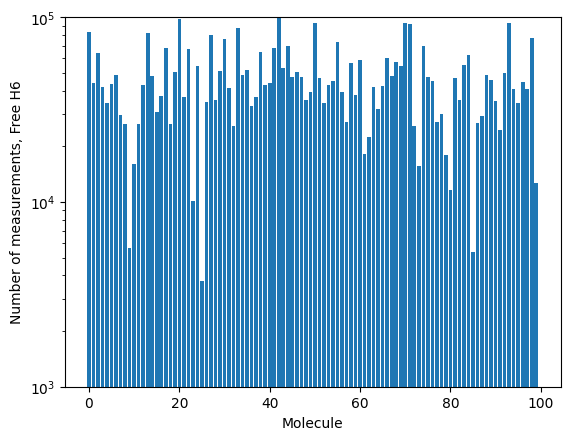

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(len(lst)), lst)
plt.yscale('log')
plt.ylim(bottom=1e3, top=3e5)
# plt.ylabel("Number of measurement groups, Free H6")
plt.ylabel("Number of measurements, Free H6")
plt.xlabel("Molecule")
plt.savefig('filename.png', dpi=300)
plt.show()